In [1]:
!pip install monai
!pip install torchmetrics
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import os
import pickle
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
from monai.utils import set_determinism
import torch
from torchmetrics import JaccardIndex
from tqdm import tqdm
from transformers import SegformerConfig, SegformerForSemanticSegmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/MyDrive/"
root_dir = os.path.join(root_dir, "ISLES-2022")
os.path.exists(root_dir)

True

In [3]:
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out) -> None:
        """
        conv_block: Convolutional block with two convolutional layers with batch normalization and ReLU activation.
        no change in size of the image.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,  padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self,ch_in,ch_out):
        """
        Upsample: Upsample the image by a factor of 2 and then apply a convolutional layer.
        No change in the size of the image.
        """
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class UNET(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super().__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2) # reduce the size of the image by half

        self.enc1 = conv_block(ch_in=img_ch,ch_out=64)
        self.enc2 = conv_block(ch_in=64,ch_out=128)
        self.enc3 = conv_block(ch_in=128,ch_out=256)
        self.enc4 = conv_block(ch_in=256,ch_out=512)

        self.bottle_neck = conv_block(ch_in=512, ch_out=1024)

        self.Upconv4 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) # increase the size of the image by 2 and decrease the number of channels by half
        self.dec4 = conv_block(ch_in=1024, ch_out=512)

        self.UpConv3 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.dec3 = conv_block(ch_in=512,ch_out=256)

        self.UpConv2 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.dec2 = conv_block(ch_in=256,ch_out=128)

        self.UpConv1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.dec1 = conv_block(ch_in=128,ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self, x):
        # x: B, img_ch, H, W


        # encoding path
        e1 = self.enc1(x)  # B, 64, H, W

        e2 = self.enc2(self.Maxpool(e1))  # B, 128, H/2, W/2
        e3 = self.enc3(self.Maxpool(e2))  # B, 256, H/4, W/4
        e4 = self.enc4(self.Maxpool(e3)) # B, 512, H/8, W/8

        bottle_neck = self.bottle_neck(self.Maxpool(e4)) # B, 1024, H/16, W/16

        d4 = self.Upconv4(bottle_neck) # B, 512, H/8, W/8
        d4 = torch.cat((d4, e4), dim=1) # B, 1024, H/8, W/8
        d4 = self.dec4(d4) # B, 512, H/8, W/8

        d3 = self.UpConv3(d4) # B, 256, H/4, W/4
        d3 = torch.cat((d3,e3),dim=1) # B, 512, H/4, W/4
        d3 = self.dec3(d3) # B, 256, H/4, W/4

        d2 = self.UpConv2(d3) # B, 128, H/2, W/2
        d2 = torch.cat((d2,e2),dim=1) # B, 256, H/2, W/2
        d2 = self.dec2(d2) # B, 128, H/2, W/2

        d1 = self.UpConv1(d2) # B, 64, H, W
        d1 = torch.cat((d1,e1),dim=1) # B, 128, H, W
        d1 = self.dec1(d1) # B, 64, H, W

        out = self.Conv_1x1(d1) # B, output_cha, H, W
        out = F.sigmoid(out)
        return out
        # Decoder path
class ResNetUNet(nn.Module):
    def __init__(self, output_ch=1):
        super().__init__()

        # Use a pretrained ResNet34 model but remove the fully connected layer and the final pooling layer
        self.resnet = models.resnet34(pretrained=True)
        self.resnet_layers = list(self.resnet.children())[:-2]
        self.resnet_encoder = nn.Sequential(*self.resnet_layers)
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2) # reduce the size of the image by half

        # Encoder channels based on ResNet34 architecture
        enc_chs = [64, 64, 128, 256, 512]

        self.bottle_neck = conv_block(ch_in=256, ch_out=512)

        # Decoder components

        self.UpConv4 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.dec4 = conv_block(ch_in=512,ch_out=256)

        self.UpConv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.dec3 = conv_block(ch_in=256,ch_out=128)

        self.UpConv2 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.dec2 = conv_block(ch_in=128,ch_out=64)

        self.UpConv1 = nn.ConvTranspose2d(64,64,kernel_size=2,stride=2)
        self.dec1 = conv_block(ch_in=128,ch_out=64)

        self.UpConv0 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        # x: B, img_ch, H, W
        e1 = self.resnet_encoder[0:3](x) # B, 64, H/2, W/2
        e2 = self.resnet_encoder[3:5](e1) # B, 64, H/4, W/4
        e3 = self.resnet_encoder[5](e2) # B, 128, H/8, H/8
        e4 = self.resnet_encoder[6](e3) # B, 256, H/16, H/16
        # print(e4.shape)

        # print(1)

        bottle_neck = self.bottle_neck(self.Maxpool(e4)) # B, 512, H/32, H/32
        # print(bottle_neck.shape)


        d4 = self.UpConv4(bottle_neck) # B, 256, H/16, H/16
        d4 = torch.cat((d4,e4),dim=1) # B, 512, H/16, H/16
        d4 = self.dec4(d4) # B, 256, H/16, H/16
        # print(d4.shape)

        d3 = self.UpConv3(d4) # B, 128, H/8, H/8
        d3 = torch.cat((d3,e3),dim=1) # B, 256, H/8, H/8
        d3 = self.dec3(d3) # B, 128, H/8, H/8
        # print(d3.shape)

        d2 = self.UpConv2(d3) # B, 64, H/4, H/4
        d2 = torch.cat((d2,e2),dim=1) # B, 128, H/4, H/4
        d2 = self.dec2(d2) # B, 64, H/4, H/4
        # print("d2", d2.shape)

        d1 = self.UpConv1(d2) # B, 64, H/2, H/2
        # print("d1", d1.shape)
        # print("e1", e1.shape)
        d1 = torch.cat((d1,e1),dim=1) # B, 64, H, H

        d0 = self.UpConv0(d1) # B, 64, H, H
        # print("d0", d0.shape)
        # print(d0.shape)


        out = self.Conv_1x1(d0) # B, output_cha, H, W
        out = F.sigmoid(out)


        return out
        # Decoder path



In [ ]:
# import custom model
from custom_model import CustomModel

### Load preprocessed data

In [ ]:
# root_dir = "."

In [ ]:
with open(os.path.join(root_dir, 'three_sequence_train_set.pkl'), 'rb') as f:
    train_set = pickle.load(f)
with open(os.path.join(root_dir, 'three_sequence_test_set.pkl'), 'rb') as f:
    test_set = pickle.load(f)

In [ ]:

# x = torch.randn(1, 3, 128, 128)
# model = CustomModel(
#         channels = [64, 128, 256, 512],
#         scale = [4, 2, 2, 2],
#         num_blocks = [2, 2, 2, 2],
#         num_heads = [2, 4, 8, 16],
#         mlp_hidden = [256, 512, 1024, 2048],
#         dropout = 0.0,                     # change to dropout rate=0.2
#         decoder_hidden = 256,
#         attention=True, # whether to use attention gate
#     )
# l =model.encoder(x)
# for i in range(len(l)):
#     print(l[i].shape)
# l.reverse()
# model.decoder(l).shape


### Define training function

In [ ]:
def get_model(model_type, device, attention_gate_flag=False):
    if model_type == "resnet":

        # model = smp.Unet(
        #     encoder_name="resnet34",
        #     in_channels=3,
        #     classes=1,
        #     activation="sigmoid",
        #     encoder_weights=None,
        # ).to(device)
        model = ResNetUNet(output_ch=1).to(device)
    elif model_type == "unet":
        # model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        # in_channels=3, out_channels=1, init_features=32, pretrained=False).to(device)
        model = UNET(img_ch=3, output_ch=1).to(device)
    elif model_type == "segformer":
        config = SegformerConfig(num_labels=1)
        model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512", num_labels=1, ignore_mismatched_sizes=True).to(device)
    elif model_type == "custom":
        model = CustomModel(
            channels = [64, 128, 256, 512],
            scale = [4, 2, 2, 2],
            num_blocks = [2, 2, 2, 2],
            num_heads = [2, 4, 8, 16],
            mlp_hidden = [256, 512, 1024, 2048],
            dropout = 0.2,                     # change to dropout rate=0.2
            decoder_hidden = 256,
            attention=attention_gate_flag, # whether to use attention gate
        ).to(device)

    return model


In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    # trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of parameters: {total_params}")
    # print(f"Number of trainable parameters: {trainable_params}")
    return total_params
# count_parameters(model)

In [ ]:
def add_model_par(df_model_par, model_type, parameters_num):
    """
    df_model_par: dataframe to save model parameters
    model_type: resnet, unet, segformer, custom
    parameters_num: number of parameters
    """
    next_index = len(df_model_par)
    df_model_par.loc[next_index] = [model_type, parameters_num]

In [ ]:
def train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=False):
    """
    model_type: resnet, unet, segformer, custom
    df_model_par: dataframe to save model parameters size
    out_dir: root directory of the dataset
    loss_function: loss function to evaluate the model, Dice or Jaccard
    metric: metric to evaluate the model, JaccardIndex(IoU) or  Dice
    device: device to train the model
    lr: learning rate
    attention_gate_flag: whether to use attention gate in custom model
    """


    model = get_model(model_type, device, attention_gate_flag=attention_gate_flag)
    add_model_par(df_model_par, model_type, count_parameters(model))
    train_ds = train_set["train"]
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_ds = train_set["val"]
    val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

    # use amp to accelerate training
    scaler = torch.cuda.amp.GradScaler()
    # enable cuDNN benchmark
    torch.backends.cudnn.benchmark = True

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    max_epochs = 200


    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")


        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                inputs.to(torch.float32)
                outputs = model(inputs)
                if model_type == "segformer":
                    outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(outputs.logits,128,mode="bilinear",align_corners=False))
                loss = loss_function(outputs, labels)

            if torch.isnan(loss) or torch.isnan(torch.flatten(outputs)).any().item():
                print(outputs)
                print(torch.isnan(torch.flatten(outputs)).any())
                print(labels)
                print(loss)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    if model_type == "segformer":
                        val_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(val_outputs.logits,128,mode="bilinear",align_corners=False))

                    # Calculate IoU
                    iou = metric(val_outputs, val_labels)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(out_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    return epoch_loss_values, metric_values


In [ ]:
def plot_train_curve(epoch_loss_values, metric_values, model_type, out_dir):

    epoch_loss_array = np.array(epoch_loss_values)
    metric_array = np.array(metric_values)
    np.savetxt(os.path.join(out_dir, 'epoch_loss_array.csv'), epoch_loss_array, delimiter=',')
    np.savetxt(os.path.join(out_dir, 'metric_array.csv'), metric_array, delimiter=',')


    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"{model_type} Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.subplot(1, 2, 2)
    plt.title(f"{model_type} Val Mean IoU ")
    x = [2 * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.savefig(os.path.join(out_dir, "train_curve.png"))
    plt.show()

# plot_train_curve(epoch_loss_values, metric_values, out_dir)




### Training

In [ ]:
gpu = "cuda"
loss = "Jaccard"

In [ ]:
if gpu == "cuda":
    device = torch.device("cuda:0")

if loss == "Dice":
    loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)
elif loss == "Jaccard":
    loss_function = smp.losses.JaccardLoss(mode="binary", from_logits=False)

metric = JaccardIndex(task="binary").to(device)

In [ ]:
loss_function, metric

(JaccardLoss(), BinaryJaccardIndex())

In [ ]:
# dataframe to save model parameters
df_model_par = pd.DataFrame(columns=['model_type', 'parameters_num'])
print(root_dir)
print(device)

/content/drive/MyDrive/ISLES-2022
cuda:0


In [ ]:
model_list = ["custom", "unet", "resnet", "segformer"]


In [ ]:
set_determinism(0) # set random seed


Total number of parameters: 51145311
----------
epoch 1/200


Training: 100%|██████████| 121/121 [00:26<00:00,  4.65it/s]


epoch 1 average loss: 0.9522
----------
epoch 2/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.75it/s]


epoch 2 average loss: 0.8737


Validation: 100%|██████████| 61/61 [00:03<00:00, 15.30it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.3704
best mean IoU: 0.3704 at epoch: 2
----------
epoch 3/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 3 average loss: 0.7153
----------
epoch 4/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 4 average loss: 0.5525


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.63it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.5476
best mean IoU: 0.5476 at epoch: 4
----------
epoch 5/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 5 average loss: 0.4335
----------
epoch 6/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.75it/s]


epoch 6 average loss: 0.3804


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.44it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.5717
best mean IoU: 0.5717 at epoch: 6
----------
epoch 7/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.72it/s]


epoch 7 average loss: 0.3381
----------
epoch 8/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 8 average loss: 0.3083


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.27it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.6329
best mean IoU: 0.6329 at epoch: 8
----------
epoch 9/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.56it/s]


epoch 9 average loss: 0.2942
----------
epoch 10/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 10 average loss: 0.2742


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.67it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.6584
best mean IoU: 0.6584 at epoch: 10
----------
epoch 11/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 11 average loss: 0.2645
----------
epoch 12/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 12 average loss: 0.2455


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.97it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.6940
best mean IoU: 0.6940 at epoch: 12
----------
epoch 13/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.72it/s]


epoch 13 average loss: 0.2345
----------
epoch 14/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 14 average loss: 0.2271


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.83it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.6981
best mean IoU: 0.6981 at epoch: 14
----------
epoch 15/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 15 average loss: 0.2252
----------
epoch 16/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 16 average loss: 0.2107


Validation: 100%|██████████| 61/61 [00:02<00:00, 22.18it/s]


current epoch: 16 current mean IoU: 0.6963
best mean IoU: 0.6981 at epoch: 14
----------
epoch 17/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.75it/s]


epoch 17 average loss: 0.2075
----------
epoch 18/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 18 average loss: 0.2068


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.91it/s]


saved new best metric model
current epoch: 18 current mean IoU: 0.7168
best mean IoU: 0.7168 at epoch: 18
----------
epoch 19/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 19 average loss: 0.1975
----------
epoch 20/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 20 average loss: 0.1918


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.07it/s]


saved new best metric model
current epoch: 20 current mean IoU: 0.7189
best mean IoU: 0.7189 at epoch: 20
----------
epoch 21/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 21 average loss: 0.1851
----------
epoch 22/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 22 average loss: 0.1819


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.30it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7239
best mean IoU: 0.7239 at epoch: 22
----------
epoch 23/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 23 average loss: 0.1756
----------
epoch 24/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.75it/s]


epoch 24 average loss: 0.1746


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.60it/s]


saved new best metric model
current epoch: 24 current mean IoU: 0.7299
best mean IoU: 0.7299 at epoch: 24
----------
epoch 25/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 25 average loss: 0.1691
----------
epoch 26/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 26 average loss: 0.1658


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.72it/s]


current epoch: 26 current mean IoU: 0.7295
best mean IoU: 0.7299 at epoch: 24
----------
epoch 27/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 27 average loss: 0.1584
----------
epoch 28/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 28 average loss: 0.1571


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.11it/s]


saved new best metric model
current epoch: 28 current mean IoU: 0.7318
best mean IoU: 0.7318 at epoch: 28
----------
epoch 29/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 29 average loss: 0.1513
----------
epoch 30/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 30 average loss: 0.1512


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.21it/s]


saved new best metric model
current epoch: 30 current mean IoU: 0.7332
best mean IoU: 0.7332 at epoch: 30
----------
epoch 31/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 31 average loss: 0.1479
----------
epoch 32/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 32 average loss: 0.1438


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.59it/s]


saved new best metric model
current epoch: 32 current mean IoU: 0.7347
best mean IoU: 0.7347 at epoch: 32
----------
epoch 33/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 33 average loss: 0.1592
----------
epoch 34/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 34 average loss: 0.1440


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.55it/s]


saved new best metric model
current epoch: 34 current mean IoU: 0.7386
best mean IoU: 0.7386 at epoch: 34
----------
epoch 35/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.59it/s]


epoch 35 average loss: 0.1402
----------
epoch 36/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 36 average loss: 0.1367


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.38it/s]


saved new best metric model
current epoch: 36 current mean IoU: 0.7453
best mean IoU: 0.7453 at epoch: 36
----------
epoch 37/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 37 average loss: 0.1343
----------
epoch 38/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 38 average loss: 0.1292


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.86it/s]


saved new best metric model
current epoch: 38 current mean IoU: 0.7466
best mean IoU: 0.7466 at epoch: 38
----------
epoch 39/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 39 average loss: 0.1289
----------
epoch 40/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 40 average loss: 0.1259


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.93it/s]


current epoch: 40 current mean IoU: 0.7460
best mean IoU: 0.7466 at epoch: 38
----------
epoch 41/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 41 average loss: 0.1263
----------
epoch 42/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 42 average loss: 0.1253


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.63it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.7477
best mean IoU: 0.7477 at epoch: 42
----------
epoch 43/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 43 average loss: 0.1242
----------
epoch 44/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 44 average loss: 0.1207


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.44it/s]


saved new best metric model
current epoch: 44 current mean IoU: 0.7510
best mean IoU: 0.7510 at epoch: 44
----------
epoch 45/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 45 average loss: 0.1170
----------
epoch 46/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.74it/s]


epoch 46 average loss: 0.1228


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.82it/s]


current epoch: 46 current mean IoU: 0.7462
best mean IoU: 0.7510 at epoch: 44
----------
epoch 47/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.73it/s]


epoch 47 average loss: 0.1155
----------
epoch 48/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.74it/s]


epoch 48 average loss: 0.1107


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.69it/s]


current epoch: 48 current mean IoU: 0.7442
best mean IoU: 0.7510 at epoch: 44
----------
epoch 49/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 49 average loss: 0.1127
----------
epoch 50/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 50 average loss: 0.1131


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.70it/s]


current epoch: 50 current mean IoU: 0.7487
best mean IoU: 0.7510 at epoch: 44
----------
epoch 51/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 51 average loss: 0.1091
----------
epoch 52/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 52 average loss: 0.1084


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.61it/s]


current epoch: 52 current mean IoU: 0.7487
best mean IoU: 0.7510 at epoch: 44
----------
epoch 53/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 53 average loss: 0.1072
----------
epoch 54/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 54 average loss: 0.1060


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.85it/s]


current epoch: 54 current mean IoU: 0.7464
best mean IoU: 0.7510 at epoch: 44
----------
epoch 55/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 55 average loss: 0.1057
----------
epoch 56/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 56 average loss: 0.1030


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.68it/s]


saved new best metric model
current epoch: 56 current mean IoU: 0.7539
best mean IoU: 0.7539 at epoch: 56
----------
epoch 57/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 57 average loss: 0.1056
----------
epoch 58/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 58 average loss: 0.1036


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.27it/s]


current epoch: 58 current mean IoU: 0.7514
best mean IoU: 0.7539 at epoch: 56
----------
epoch 59/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 59 average loss: 0.1009
----------
epoch 60/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.77it/s]


epoch 60 average loss: 0.1000


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.61it/s]


current epoch: 60 current mean IoU: 0.7507
best mean IoU: 0.7539 at epoch: 56
----------
epoch 61/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.77it/s]


epoch 61 average loss: 0.1001
----------
epoch 62/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.78it/s]


epoch 62 average loss: 0.0958


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.49it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.7547
best mean IoU: 0.7547 at epoch: 62
----------
epoch 63/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 63 average loss: 0.0968
----------
epoch 64/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 64 average loss: 0.0956


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.53it/s]


current epoch: 64 current mean IoU: 0.7536
best mean IoU: 0.7547 at epoch: 62
----------
epoch 65/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 65 average loss: 0.0938
----------
epoch 66/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 66 average loss: 0.0969


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.80it/s]


current epoch: 66 current mean IoU: 0.7538
best mean IoU: 0.7547 at epoch: 62
----------
epoch 67/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 67 average loss: 0.0964
----------
epoch 68/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 68 average loss: 0.0928


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.03it/s]


current epoch: 68 current mean IoU: 0.7520
best mean IoU: 0.7547 at epoch: 62
----------
epoch 69/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 69 average loss: 0.0900
----------
epoch 70/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 70 average loss: 0.0941


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.38it/s]


current epoch: 70 current mean IoU: 0.7498
best mean IoU: 0.7547 at epoch: 62
----------
epoch 71/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 71 average loss: 0.0934
----------
epoch 72/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 72 average loss: 0.0917


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.44it/s]


saved new best metric model
current epoch: 72 current mean IoU: 0.7586
best mean IoU: 0.7586 at epoch: 72
----------
epoch 73/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 73 average loss: 0.0877
----------
epoch 74/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.75it/s]


epoch 74 average loss: 0.0896


Validation: 100%|██████████| 61/61 [00:02<00:00, 22.02it/s]


current epoch: 74 current mean IoU: 0.7573
best mean IoU: 0.7586 at epoch: 72
----------
epoch 75/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 75 average loss: 0.0855
----------
epoch 76/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 76 average loss: 0.0876


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.98it/s]


current epoch: 76 current mean IoU: 0.7567
best mean IoU: 0.7586 at epoch: 72
----------
epoch 77/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 77 average loss: 0.0844
----------
epoch 78/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 78 average loss: 0.0847


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.49it/s]


current epoch: 78 current mean IoU: 0.7583
best mean IoU: 0.7586 at epoch: 72
----------
epoch 79/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 79 average loss: 0.0855
----------
epoch 80/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 80 average loss: 0.0842


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.55it/s]


current epoch: 80 current mean IoU: 0.7572
best mean IoU: 0.7586 at epoch: 72
----------
epoch 81/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 81 average loss: 0.0838
----------
epoch 82/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 82 average loss: 0.0826


Validation: 100%|██████████| 61/61 [00:02<00:00, 22.00it/s]


current epoch: 82 current mean IoU: 0.7583
best mean IoU: 0.7586 at epoch: 72
----------
epoch 83/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 83 average loss: 0.0819
----------
epoch 84/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 84 average loss: 0.0848


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.01it/s]


saved new best metric model
current epoch: 84 current mean IoU: 0.7604
best mean IoU: 0.7604 at epoch: 84
----------
epoch 85/200


Training: 100%|██████████| 121/121 [00:16<00:00,  7.30it/s]


epoch 85 average loss: 0.0832
----------
epoch 86/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 86 average loss: 0.0820


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.94it/s]


current epoch: 86 current mean IoU: 0.7604
best mean IoU: 0.7604 at epoch: 84
----------
epoch 87/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 87 average loss: 0.0824
----------
epoch 88/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.74it/s]


epoch 88 average loss: 0.0841


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.52it/s]


current epoch: 88 current mean IoU: 0.7548
best mean IoU: 0.7604 at epoch: 84
----------
epoch 89/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 89 average loss: 0.0827
----------
epoch 90/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 90 average loss: 0.0817


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.86it/s]


current epoch: 90 current mean IoU: 0.7591
best mean IoU: 0.7604 at epoch: 84
----------
epoch 91/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 91 average loss: 0.0813
----------
epoch 92/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 92 average loss: 0.0792


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.37it/s]


current epoch: 92 current mean IoU: 0.7554
best mean IoU: 0.7604 at epoch: 84
----------
epoch 93/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 93 average loss: 0.0886
----------
epoch 94/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 94 average loss: 0.0788


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.29it/s]


saved new best metric model
current epoch: 94 current mean IoU: 0.7614
best mean IoU: 0.7614 at epoch: 94
----------
epoch 95/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.57it/s]


epoch 95 average loss: 0.0783
----------
epoch 96/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.74it/s]


epoch 96 average loss: 0.0755


Validation: 100%|██████████| 61/61 [00:02<00:00, 22.00it/s]


current epoch: 96 current mean IoU: 0.7592
best mean IoU: 0.7614 at epoch: 94
----------
epoch 97/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 97 average loss: 0.0793
----------
epoch 98/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 98 average loss: 0.0791


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.75it/s]


current epoch: 98 current mean IoU: 0.7594
best mean IoU: 0.7614 at epoch: 94
----------
epoch 99/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 99 average loss: 0.0747
----------
epoch 100/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 100 average loss: 0.0733


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.81it/s]


current epoch: 100 current mean IoU: 0.7588
best mean IoU: 0.7614 at epoch: 94
----------
epoch 101/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.72it/s]


epoch 101 average loss: 0.0757
----------
epoch 102/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 102 average loss: 0.0749


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.78it/s]


current epoch: 102 current mean IoU: 0.7601
best mean IoU: 0.7614 at epoch: 94
----------
epoch 103/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 103 average loss: 0.0742
----------
epoch 104/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.72it/s]


epoch 104 average loss: 0.0728


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.83it/s]


current epoch: 104 current mean IoU: 0.7591
best mean IoU: 0.7614 at epoch: 94
----------
epoch 105/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.59it/s]


epoch 105 average loss: 0.0750
----------
epoch 106/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 106 average loss: 0.0737


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.09it/s]


current epoch: 106 current mean IoU: 0.7567
best mean IoU: 0.7614 at epoch: 94
----------
epoch 107/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 107 average loss: 0.0725
----------
epoch 108/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.73it/s]


epoch 108 average loss: 0.0738


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.53it/s]


current epoch: 108 current mean IoU: 0.7569
best mean IoU: 0.7614 at epoch: 94
----------
epoch 109/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 109 average loss: 0.0732
----------
epoch 110/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 110 average loss: 0.0716


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.92it/s]


saved new best metric model
current epoch: 110 current mean IoU: 0.7620
best mean IoU: 0.7620 at epoch: 110
----------
epoch 111/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 111 average loss: 0.0710
----------
epoch 112/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 112 average loss: 0.0708


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.72it/s]


current epoch: 112 current mean IoU: 0.7609
best mean IoU: 0.7620 at epoch: 110
----------
epoch 113/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 113 average loss: 0.0758
----------
epoch 114/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 114 average loss: 0.0737


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.48it/s]


current epoch: 114 current mean IoU: 0.7615
best mean IoU: 0.7620 at epoch: 110
----------
epoch 115/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 115 average loss: 0.0678
----------
epoch 116/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 116 average loss: 0.0713


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.44it/s]


saved new best metric model
current epoch: 116 current mean IoU: 0.7625
best mean IoU: 0.7625 at epoch: 116
----------
epoch 117/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 117 average loss: 0.0695
----------
epoch 118/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.69it/s]


epoch 118 average loss: 0.0709


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.38it/s]


current epoch: 118 current mean IoU: 0.7615
best mean IoU: 0.7625 at epoch: 116
----------
epoch 119/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 119 average loss: 0.0688
----------
epoch 120/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 120 average loss: 0.0654


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.46it/s]


current epoch: 120 current mean IoU: 0.7612
best mean IoU: 0.7625 at epoch: 116
----------
epoch 121/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 121 average loss: 0.0675
----------
epoch 122/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 122 average loss: 0.0719


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.71it/s]


current epoch: 122 current mean IoU: 0.7621
best mean IoU: 0.7625 at epoch: 116
----------
epoch 123/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 123 average loss: 0.0703
----------
epoch 124/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 124 average loss: 0.0686


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.75it/s]


saved new best metric model
current epoch: 124 current mean IoU: 0.7635
best mean IoU: 0.7635 at epoch: 124
----------
epoch 125/200


Training: 100%|██████████| 121/121 [00:16<00:00,  7.50it/s]


epoch 125 average loss: 0.0690
----------
epoch 126/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 126 average loss: 0.0684


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.27it/s]


current epoch: 126 current mean IoU: 0.7628
best mean IoU: 0.7635 at epoch: 124
----------
epoch 127/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 127 average loss: 0.0685
----------
epoch 128/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 128 average loss: 0.0676


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.51it/s]


current epoch: 128 current mean IoU: 0.7630
best mean IoU: 0.7635 at epoch: 124
----------
epoch 129/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 129 average loss: 0.0674
----------
epoch 130/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 130 average loss: 0.0689


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.31it/s]


current epoch: 130 current mean IoU: 0.7587
best mean IoU: 0.7635 at epoch: 124
----------
epoch 131/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 131 average loss: 0.0674
----------
epoch 132/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 132 average loss: 0.0687


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.98it/s]


current epoch: 132 current mean IoU: 0.7598
best mean IoU: 0.7635 at epoch: 124
----------
epoch 133/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 133 average loss: 0.0679
----------
epoch 134/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 134 average loss: 0.0647


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.86it/s]


saved new best metric model
current epoch: 134 current mean IoU: 0.7662
best mean IoU: 0.7662 at epoch: 134
----------
epoch 135/200


Training: 100%|██████████| 121/121 [00:16<00:00,  7.47it/s]


epoch 135 average loss: 0.0633
----------
epoch 136/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 136 average loss: 0.0680


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.21it/s]


current epoch: 136 current mean IoU: 0.7644
best mean IoU: 0.7662 at epoch: 134
----------
epoch 137/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 137 average loss: 0.0665
----------
epoch 138/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 138 average loss: 0.0647


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.49it/s]


saved new best metric model
current epoch: 138 current mean IoU: 0.7679
best mean IoU: 0.7679 at epoch: 138
----------
epoch 139/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.59it/s]


epoch 139 average loss: 0.0627
----------
epoch 140/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 140 average loss: 0.0652


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.35it/s]


current epoch: 140 current mean IoU: 0.7649
best mean IoU: 0.7679 at epoch: 138
----------
epoch 141/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 141 average loss: 0.0652
----------
epoch 142/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 142 average loss: 0.0636


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.61it/s]


current epoch: 142 current mean IoU: 0.7652
best mean IoU: 0.7679 at epoch: 138
----------
epoch 143/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 143 average loss: 0.0637
----------
epoch 144/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 144 average loss: 0.0615


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.08it/s]


current epoch: 144 current mean IoU: 0.7641
best mean IoU: 0.7679 at epoch: 138
----------
epoch 145/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 145 average loss: 0.0647
----------
epoch 146/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 146 average loss: 0.0623


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.38it/s]


current epoch: 146 current mean IoU: 0.7642
best mean IoU: 0.7679 at epoch: 138
----------
epoch 147/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 147 average loss: 0.0651
----------
epoch 148/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 148 average loss: 0.0665


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.35it/s]


current epoch: 148 current mean IoU: 0.7632
best mean IoU: 0.7679 at epoch: 138
----------
epoch 149/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 149 average loss: 0.0629
----------
epoch 150/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 150 average loss: 0.0611


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.83it/s]


current epoch: 150 current mean IoU: 0.7579
best mean IoU: 0.7679 at epoch: 138
----------
epoch 151/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 151 average loss: 0.0634
----------
epoch 152/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 152 average loss: 0.0606


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.00it/s]


current epoch: 152 current mean IoU: 0.7646
best mean IoU: 0.7679 at epoch: 138
----------
epoch 153/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 153 average loss: 0.0626
----------
epoch 154/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 154 average loss: 0.0593


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.66it/s]


current epoch: 154 current mean IoU: 0.7661
best mean IoU: 0.7679 at epoch: 138
----------
epoch 155/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 155 average loss: 0.0620
----------
epoch 156/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 156 average loss: 0.0621


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.44it/s]


current epoch: 156 current mean IoU: 0.7659
best mean IoU: 0.7679 at epoch: 138
----------
epoch 157/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 157 average loss: 0.0597
----------
epoch 158/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 158 average loss: 0.0631


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.13it/s]


current epoch: 158 current mean IoU: 0.7651
best mean IoU: 0.7679 at epoch: 138
----------
epoch 159/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 159 average loss: 0.0611
----------
epoch 160/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 160 average loss: 0.0614


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.84it/s]


current epoch: 160 current mean IoU: 0.7625
best mean IoU: 0.7679 at epoch: 138
----------
epoch 161/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 161 average loss: 0.0687
----------
epoch 162/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 162 average loss: 0.0631


Validation: 100%|██████████| 61/61 [00:02<00:00, 22.09it/s]


current epoch: 162 current mean IoU: 0.7624
best mean IoU: 0.7679 at epoch: 138
----------
epoch 163/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 163 average loss: 0.0570
----------
epoch 164/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 164 average loss: 0.0607


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.18it/s]


current epoch: 164 current mean IoU: 0.7670
best mean IoU: 0.7679 at epoch: 138
----------
epoch 165/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 165 average loss: 0.0579
----------
epoch 166/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 166 average loss: 0.0579


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.44it/s]


current epoch: 166 current mean IoU: 0.7673
best mean IoU: 0.7679 at epoch: 138
----------
epoch 167/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 167 average loss: 0.0559
----------
epoch 168/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 168 average loss: 0.0560


Validation: 100%|██████████| 61/61 [00:02<00:00, 20.53it/s]


current epoch: 168 current mean IoU: 0.7635
best mean IoU: 0.7679 at epoch: 138
----------
epoch 169/200


Training: 100%|██████████| 121/121 [00:16<00:00,  7.56it/s]


epoch 169 average loss: 0.0576
----------
epoch 170/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 170 average loss: 0.0608


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.43it/s]


current epoch: 170 current mean IoU: 0.7673
best mean IoU: 0.7679 at epoch: 138
----------
epoch 171/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.59it/s]


epoch 171 average loss: 0.0590
----------
epoch 172/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 172 average loss: 0.0575


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.55it/s]


current epoch: 172 current mean IoU: 0.7637
best mean IoU: 0.7679 at epoch: 138
----------
epoch 173/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 173 average loss: 0.0563
----------
epoch 174/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.59it/s]


epoch 174 average loss: 0.0619


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.31it/s]


current epoch: 174 current mean IoU: 0.7639
best mean IoU: 0.7679 at epoch: 138
----------
epoch 175/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 175 average loss: 0.0604
----------
epoch 176/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 176 average loss: 0.0575


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.97it/s]


current epoch: 176 current mean IoU: 0.7646
best mean IoU: 0.7679 at epoch: 138
----------
epoch 177/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 177 average loss: 0.0614
----------
epoch 178/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 178 average loss: 0.0559


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.14it/s]


current epoch: 178 current mean IoU: 0.7663
best mean IoU: 0.7679 at epoch: 138
----------
epoch 179/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 179 average loss: 0.0582
----------
epoch 180/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.66it/s]


epoch 180 average loss: 0.0564


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.52it/s]


current epoch: 180 current mean IoU: 0.7662
best mean IoU: 0.7679 at epoch: 138
----------
epoch 181/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 181 average loss: 0.0585
----------
epoch 182/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 182 average loss: 0.0587


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.53it/s]


current epoch: 182 current mean IoU: 0.7619
best mean IoU: 0.7679 at epoch: 138
----------
epoch 183/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 183 average loss: 0.0589
----------
epoch 184/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 184 average loss: 0.0595


Validation: 100%|██████████| 61/61 [00:03<00:00, 20.18it/s]


current epoch: 184 current mean IoU: 0.7673
best mean IoU: 0.7679 at epoch: 138
----------
epoch 185/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.57it/s]


epoch 185 average loss: 0.0576
----------
epoch 186/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 186 average loss: 0.0580


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.11it/s]


current epoch: 186 current mean IoU: 0.7632
best mean IoU: 0.7679 at epoch: 138
----------
epoch 187/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 187 average loss: 0.0549
----------
epoch 188/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.70it/s]


epoch 188 average loss: 0.0579


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.66it/s]


current epoch: 188 current mean IoU: 0.7654
best mean IoU: 0.7679 at epoch: 138
----------
epoch 189/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 189 average loss: 0.0543
----------
epoch 190/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.64it/s]


epoch 190 average loss: 0.0540


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.69it/s]


current epoch: 190 current mean IoU: 0.7668
best mean IoU: 0.7679 at epoch: 138
----------
epoch 191/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.71it/s]


epoch 191 average loss: 0.0573
----------
epoch 192/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.62it/s]


epoch 192 average loss: 0.0583


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.00it/s]


current epoch: 192 current mean IoU: 0.7639
best mean IoU: 0.7679 at epoch: 138
----------
epoch 193/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.60it/s]


epoch 193 average loss: 0.0558
----------
epoch 194/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.67it/s]


epoch 194 average loss: 0.0552


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.27it/s]


current epoch: 194 current mean IoU: 0.7661
best mean IoU: 0.7679 at epoch: 138
----------
epoch 195/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.68it/s]


epoch 195 average loss: 0.0579
----------
epoch 196/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.61it/s]


epoch 196 average loss: 0.0550


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.04it/s]


saved new best metric model
current epoch: 196 current mean IoU: 0.7681
best mean IoU: 0.7681 at epoch: 196
----------
epoch 197/200


Training: 100%|██████████| 121/121 [00:16<00:00,  7.55it/s]


epoch 197 average loss: 0.0513
----------
epoch 198/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.63it/s]


epoch 198 average loss: 0.0564


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.49it/s]


saved new best metric model
current epoch: 198 current mean IoU: 0.7699
best mean IoU: 0.7699 at epoch: 198
----------
epoch 199/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.65it/s]


epoch 199 average loss: 0.0568
----------
epoch 200/200


Training: 100%|██████████| 121/121 [00:15<00:00,  7.59it/s]


epoch 200 average loss: 0.0569


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.58it/s]


current epoch: 200 current mean IoU: 0.7677
best mean IoU: 0.7699 at epoch: 198


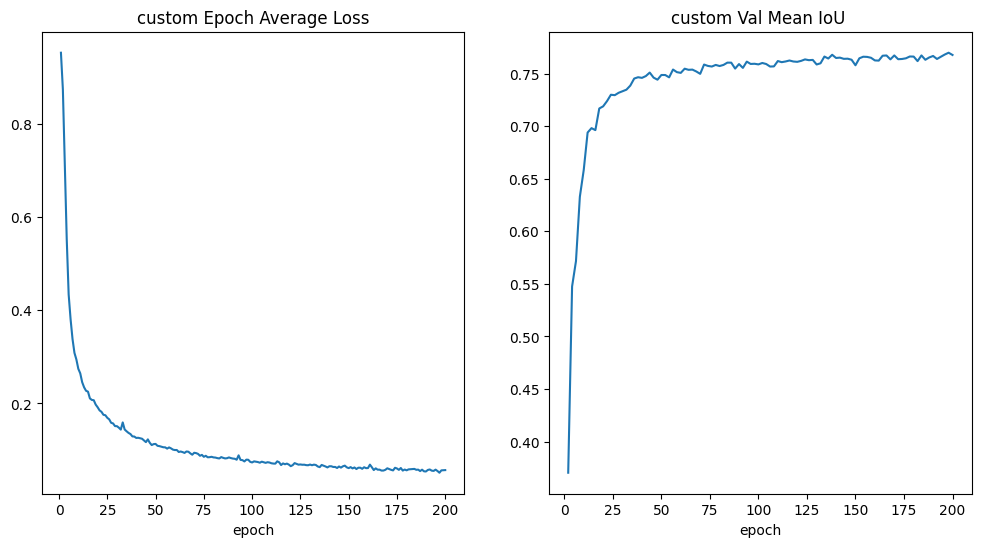

Total number of parameters: 31043521
----------
epoch 1/200


Training: 100%|██████████| 121/121 [00:08<00:00, 13.64it/s]


epoch 1 average loss: 0.9669
----------
epoch 2/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.26it/s]


epoch 2 average loss: 0.9534


Validation: 100%|██████████| 61/61 [00:01<00:00, 34.74it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.2968
best mean IoU: 0.2968 at epoch: 2
----------
epoch 3/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.36it/s]


epoch 3 average loss: 0.9385
----------
epoch 4/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.10it/s]


epoch 4 average loss: 0.9140


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.32it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.4416
best mean IoU: 0.4416 at epoch: 4
----------
epoch 5/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.52it/s]


epoch 5 average loss: 0.8685
----------
epoch 6/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 6 average loss: 0.8012


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.39it/s]


current epoch: 6 current mean IoU: 0.3698
best mean IoU: 0.4416 at epoch: 4
----------
epoch 7/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 7 average loss: 0.7016
----------
epoch 8/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 8 average loss: 0.5953


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.52it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.6389
best mean IoU: 0.6389 at epoch: 8
----------
epoch 9/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 9 average loss: 0.4931
----------
epoch 10/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.33it/s]


epoch 10 average loss: 0.4229


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.76it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.6935
best mean IoU: 0.6935 at epoch: 10
----------
epoch 11/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.29it/s]


epoch 11 average loss: 0.3643
----------
epoch 12/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.25it/s]


epoch 12 average loss: 0.3296


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.43it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.6953
best mean IoU: 0.6953 at epoch: 12
----------
epoch 13/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 13 average loss: 0.3112
----------
epoch 14/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 14 average loss: 0.2832


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.54it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.7200
best mean IoU: 0.7200 at epoch: 14
----------
epoch 15/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.55it/s]


epoch 15 average loss: 0.2601
----------
epoch 16/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


epoch 16 average loss: 0.2723


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.99it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.7266
best mean IoU: 0.7266 at epoch: 16
----------
epoch 17/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.28it/s]


epoch 17 average loss: 0.2431
----------
epoch 18/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.27it/s]


epoch 18 average loss: 0.2338


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.64it/s]


saved new best metric model
current epoch: 18 current mean IoU: 0.7451
best mean IoU: 0.7451 at epoch: 18
----------
epoch 19/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 19 average loss: 0.2261
----------
epoch 20/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.30it/s]


epoch 20 average loss: 0.2243


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.98it/s]


current epoch: 20 current mean IoU: 0.7320
best mean IoU: 0.7451 at epoch: 18
----------
epoch 21/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.28it/s]


epoch 21 average loss: 0.2174
----------
epoch 22/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.38it/s]


epoch 22 average loss: 0.2101


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.71it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7638
best mean IoU: 0.7638 at epoch: 22
----------
epoch 23/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.20it/s]


epoch 23 average loss: 0.1979
----------
epoch 24/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.42it/s]


epoch 24 average loss: 0.1977


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.78it/s]


current epoch: 24 current mean IoU: 0.7496
best mean IoU: 0.7638 at epoch: 22
----------
epoch 25/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.49it/s]


epoch 25 average loss: 0.1942
----------
epoch 26/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.20it/s]


epoch 26 average loss: 0.1942


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.65it/s]


saved new best metric model
current epoch: 26 current mean IoU: 0.7714
best mean IoU: 0.7714 at epoch: 26
----------
epoch 27/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.25it/s]


epoch 27 average loss: 0.1832
----------
epoch 28/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.08it/s]


epoch 28 average loss: 0.1834


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.64it/s]


saved new best metric model
current epoch: 28 current mean IoU: 0.7761
best mean IoU: 0.7761 at epoch: 28
----------
epoch 29/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.43it/s]


epoch 29 average loss: 0.1779
----------
epoch 30/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.27it/s]


epoch 30 average loss: 0.1765


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.88it/s]


current epoch: 30 current mean IoU: 0.7665
best mean IoU: 0.7761 at epoch: 28
----------
epoch 31/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 31 average loss: 0.1730
----------
epoch 32/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.38it/s]


epoch 32 average loss: 0.1706


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.26it/s]


current epoch: 32 current mean IoU: 0.7651
best mean IoU: 0.7761 at epoch: 28
----------
epoch 33/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.42it/s]


epoch 33 average loss: 0.1678
----------
epoch 34/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.23it/s]


epoch 34 average loss: 0.1707


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.49it/s]


current epoch: 34 current mean IoU: 0.7636
best mean IoU: 0.7761 at epoch: 28
----------
epoch 35/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.27it/s]


epoch 35 average loss: 0.1677
----------
epoch 36/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.37it/s]


epoch 36 average loss: 0.1620


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.73it/s]


saved new best metric model
current epoch: 36 current mean IoU: 0.7775
best mean IoU: 0.7775 at epoch: 36
----------
epoch 37/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.42it/s]


epoch 37 average loss: 0.1599
----------
epoch 38/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 38 average loss: 0.1598


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.85it/s]


current epoch: 38 current mean IoU: 0.7645
best mean IoU: 0.7775 at epoch: 36
----------
epoch 39/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.43it/s]


epoch 39 average loss: 0.1567
----------
epoch 40/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.39it/s]


epoch 40 average loss: 0.1563


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.53it/s]


saved new best metric model
current epoch: 40 current mean IoU: 0.7820
best mean IoU: 0.7820 at epoch: 40
----------
epoch 41/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.31it/s]


epoch 41 average loss: 0.1519
----------
epoch 42/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 42 average loss: 0.1497


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.63it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.7826
best mean IoU: 0.7826 at epoch: 42
----------
epoch 43/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.42it/s]


epoch 43 average loss: 0.1464
----------
epoch 44/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.30it/s]


epoch 44 average loss: 0.1479


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.94it/s]


current epoch: 44 current mean IoU: 0.7695
best mean IoU: 0.7826 at epoch: 42
----------
epoch 45/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.31it/s]


epoch 45 average loss: 0.1470
----------
epoch 46/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.62it/s]


epoch 46 average loss: 0.1470


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.13it/s]


saved new best metric model
current epoch: 46 current mean IoU: 0.7867
best mean IoU: 0.7867 at epoch: 46
----------
epoch 47/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 47 average loss: 0.1464
----------
epoch 48/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 48 average loss: 0.1439


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.73it/s]


current epoch: 48 current mean IoU: 0.7825
best mean IoU: 0.7867 at epoch: 46
----------
epoch 49/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 49 average loss: 0.1419
----------
epoch 50/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.37it/s]


epoch 50 average loss: 0.1375


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.25it/s]


current epoch: 50 current mean IoU: 0.7856
best mean IoU: 0.7867 at epoch: 46
----------
epoch 51/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.65it/s]


epoch 51 average loss: 0.1373
----------
epoch 52/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 52 average loss: 0.1334


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.53it/s]


saved new best metric model
current epoch: 52 current mean IoU: 0.7906
best mean IoU: 0.7906 at epoch: 52
----------
epoch 53/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 53 average loss: 0.1385
----------
epoch 54/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.21it/s]


epoch 54 average loss: 0.1370


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.70it/s]


current epoch: 54 current mean IoU: 0.7843
best mean IoU: 0.7906 at epoch: 52
----------
epoch 55/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.35it/s]


epoch 55 average loss: 0.1312
----------
epoch 56/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 56 average loss: 0.1328


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.73it/s]


current epoch: 56 current mean IoU: 0.7887
best mean IoU: 0.7906 at epoch: 52
----------
epoch 57/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 57 average loss: 0.1338
----------
epoch 58/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 58 average loss: 0.1355


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.20it/s]


current epoch: 58 current mean IoU: 0.7867
best mean IoU: 0.7906 at epoch: 52
----------
epoch 59/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 59 average loss: 0.1305
----------
epoch 60/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 60 average loss: 0.1318


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.50it/s]


current epoch: 60 current mean IoU: 0.7827
best mean IoU: 0.7906 at epoch: 52
----------
epoch 61/200


Training: 100%|██████████| 121/121 [00:07<00:00, 16.98it/s]


epoch 61 average loss: 0.1261
----------
epoch 62/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 62 average loss: 0.1278


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.92it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.7935
best mean IoU: 0.7935 at epoch: 62
----------
epoch 63/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 63 average loss: 0.1283
----------
epoch 64/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 64 average loss: 0.1223


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.05it/s]


current epoch: 64 current mean IoU: 0.7877
best mean IoU: 0.7935 at epoch: 62
----------
epoch 65/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 65 average loss: 0.1218
----------
epoch 66/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 66 average loss: 0.1224


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.32it/s]


current epoch: 66 current mean IoU: 0.7925
best mean IoU: 0.7935 at epoch: 62
----------
epoch 67/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.24it/s]


epoch 67 average loss: 0.1237
----------
epoch 68/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 68 average loss: 0.1206


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.71it/s]


current epoch: 68 current mean IoU: 0.7915
best mean IoU: 0.7935 at epoch: 62
----------
epoch 69/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.46it/s]


epoch 69 average loss: 0.1164
----------
epoch 70/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.49it/s]


epoch 70 average loss: 0.1195


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.24it/s]


saved new best metric model
current epoch: 70 current mean IoU: 0.7963
best mean IoU: 0.7963 at epoch: 70
----------
epoch 71/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.37it/s]


epoch 71 average loss: 0.1182
----------
epoch 72/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.30it/s]


epoch 72 average loss: 0.1166


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.53it/s]


current epoch: 72 current mean IoU: 0.7906
best mean IoU: 0.7963 at epoch: 70
----------
epoch 73/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 73 average loss: 0.1181
----------
epoch 74/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 74 average loss: 0.1170


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.19it/s]


current epoch: 74 current mean IoU: 0.7905
best mean IoU: 0.7963 at epoch: 70
----------
epoch 75/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.42it/s]


epoch 75 average loss: 0.1157
----------
epoch 76/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.67it/s]


epoch 76 average loss: 0.1125


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.48it/s]


current epoch: 76 current mean IoU: 0.7917
best mean IoU: 0.7963 at epoch: 70
----------
epoch 77/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.39it/s]


epoch 77 average loss: 0.1152
----------
epoch 78/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 78 average loss: 0.1128


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.65it/s]


current epoch: 78 current mean IoU: 0.7926
best mean IoU: 0.7963 at epoch: 70
----------
epoch 79/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 79 average loss: 0.1145
----------
epoch 80/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 80 average loss: 0.1130


Validation: 100%|██████████| 61/61 [00:01<00:00, 51.09it/s]


current epoch: 80 current mean IoU: 0.7958
best mean IoU: 0.7963 at epoch: 70
----------
epoch 81/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 81 average loss: 0.1103
----------
epoch 82/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 82 average loss: 0.1080


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.56it/s]


current epoch: 82 current mean IoU: 0.7944
best mean IoU: 0.7963 at epoch: 70
----------
epoch 83/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 83 average loss: 0.1066
----------
epoch 84/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.64it/s]


epoch 84 average loss: 0.1077


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.69it/s]


current epoch: 84 current mean IoU: 0.7947
best mean IoU: 0.7963 at epoch: 70
----------
epoch 85/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 85 average loss: 0.1094
----------
epoch 86/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.72it/s]


epoch 86 average loss: 0.1082


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.56it/s]


current epoch: 86 current mean IoU: 0.7894
best mean IoU: 0.7963 at epoch: 70
----------
epoch 87/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.36it/s]


epoch 87 average loss: 0.1066
----------
epoch 88/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.29it/s]


epoch 88 average loss: 0.1070


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.80it/s]


current epoch: 88 current mean IoU: 0.7932
best mean IoU: 0.7963 at epoch: 70
----------
epoch 89/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 89 average loss: 0.1082
----------
epoch 90/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.57it/s]


epoch 90 average loss: 0.1034


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.71it/s]


current epoch: 90 current mean IoU: 0.7944
best mean IoU: 0.7963 at epoch: 70
----------
epoch 91/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.39it/s]


epoch 91 average loss: 0.1026
----------
epoch 92/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.43it/s]


epoch 92 average loss: 0.1050


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.68it/s]


current epoch: 92 current mean IoU: 0.7946
best mean IoU: 0.7963 at epoch: 70
----------
epoch 93/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.37it/s]


epoch 93 average loss: 0.1039
----------
epoch 94/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 94 average loss: 0.1021


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.54it/s]


current epoch: 94 current mean IoU: 0.7844
best mean IoU: 0.7963 at epoch: 70
----------
epoch 95/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 95 average loss: 0.1052
----------
epoch 96/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.35it/s]


epoch 96 average loss: 0.1013


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.13it/s]


current epoch: 96 current mean IoU: 0.7907
best mean IoU: 0.7963 at epoch: 70
----------
epoch 97/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.70it/s]


epoch 97 average loss: 0.1046
----------
epoch 98/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.61it/s]


epoch 98 average loss: 0.1010


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.19it/s]


current epoch: 98 current mean IoU: 0.7956
best mean IoU: 0.7963 at epoch: 70
----------
epoch 99/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 99 average loss: 0.0990
----------
epoch 100/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.55it/s]


epoch 100 average loss: 0.0997


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.74it/s]


current epoch: 100 current mean IoU: 0.7905
best mean IoU: 0.7963 at epoch: 70
----------
epoch 101/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 101 average loss: 0.1010
----------
epoch 102/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.54it/s]


epoch 102 average loss: 0.0996


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.11it/s]


saved new best metric model
current epoch: 102 current mean IoU: 0.7964
best mean IoU: 0.7964 at epoch: 102
----------
epoch 103/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.57it/s]


epoch 103 average loss: 0.0987
----------
epoch 104/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.30it/s]


epoch 104 average loss: 0.0990


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.28it/s]


saved new best metric model
current epoch: 104 current mean IoU: 0.7972
best mean IoU: 0.7972 at epoch: 104
----------
epoch 105/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 105 average loss: 0.0981
----------
epoch 106/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.38it/s]


epoch 106 average loss: 0.0975


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.90it/s]


current epoch: 106 current mean IoU: 0.7961
best mean IoU: 0.7972 at epoch: 104
----------
epoch 107/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.21it/s]


epoch 107 average loss: 0.0955
----------
epoch 108/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 108 average loss: 0.0958


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.25it/s]


saved new best metric model
current epoch: 108 current mean IoU: 0.8031
best mean IoU: 0.8031 at epoch: 108
----------
epoch 109/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.32it/s]


epoch 109 average loss: 0.0927
----------
epoch 110/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.29it/s]


epoch 110 average loss: 0.0946


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.04it/s]


current epoch: 110 current mean IoU: 0.7980
best mean IoU: 0.8031 at epoch: 108
----------
epoch 111/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.57it/s]


epoch 111 average loss: 0.0944
----------
epoch 112/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 112 average loss: 0.0940


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.63it/s]


current epoch: 112 current mean IoU: 0.7887
best mean IoU: 0.8031 at epoch: 108
----------
epoch 113/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 113 average loss: 0.0964
----------
epoch 114/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 114 average loss: 0.0934


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.05it/s]


current epoch: 114 current mean IoU: 0.7985
best mean IoU: 0.8031 at epoch: 108
----------
epoch 115/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.23it/s]


epoch 115 average loss: 0.0940
----------
epoch 116/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 116 average loss: 0.0958


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.26it/s]


current epoch: 116 current mean IoU: 0.7999
best mean IoU: 0.8031 at epoch: 108
----------
epoch 117/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.24it/s]


epoch 117 average loss: 0.0915
----------
epoch 118/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 118 average loss: 0.0906


Validation: 100%|██████████| 61/61 [00:01<00:00, 45.32it/s]


current epoch: 118 current mean IoU: 0.7988
best mean IoU: 0.8031 at epoch: 108
----------
epoch 119/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.42it/s]


epoch 119 average loss: 0.0887
----------
epoch 120/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.31it/s]


epoch 120 average loss: 0.0916


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.20it/s]


current epoch: 120 current mean IoU: 0.7950
best mean IoU: 0.8031 at epoch: 108
----------
epoch 121/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.43it/s]


epoch 121 average loss: 0.0885
----------
epoch 122/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.14it/s]


epoch 122 average loss: 0.0906


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.96it/s]


current epoch: 122 current mean IoU: 0.7945
best mean IoU: 0.8031 at epoch: 108
----------
epoch 123/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.36it/s]


epoch 123 average loss: 0.0894
----------
epoch 124/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 124 average loss: 0.0886


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.62it/s]


current epoch: 124 current mean IoU: 0.7925
best mean IoU: 0.8031 at epoch: 108
----------
epoch 125/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 125 average loss: 0.0883
----------
epoch 126/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.31it/s]


epoch 126 average loss: 0.0912


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.72it/s]


current epoch: 126 current mean IoU: 0.7963
best mean IoU: 0.8031 at epoch: 108
----------
epoch 127/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.28it/s]


epoch 127 average loss: 0.0869
----------
epoch 128/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.32it/s]


epoch 128 average loss: 0.0863


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.19it/s]


current epoch: 128 current mean IoU: 0.7938
best mean IoU: 0.8031 at epoch: 108
----------
epoch 129/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 129 average loss: 0.0878
----------
epoch 130/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 130 average loss: 0.0850


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.29it/s]


current epoch: 130 current mean IoU: 0.8009
best mean IoU: 0.8031 at epoch: 108
----------
epoch 131/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 131 average loss: 0.0859
----------
epoch 132/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.58it/s]


epoch 132 average loss: 0.0838


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.35it/s]


current epoch: 132 current mean IoU: 0.7962
best mean IoU: 0.8031 at epoch: 108
----------
epoch 133/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.63it/s]


epoch 133 average loss: 0.0849
----------
epoch 134/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.43it/s]


epoch 134 average loss: 0.0852


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.53it/s]


current epoch: 134 current mean IoU: 0.7837
best mean IoU: 0.8031 at epoch: 108
----------
epoch 135/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 135 average loss: 0.0857
----------
epoch 136/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


epoch 136 average loss: 0.0840


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.11it/s]


current epoch: 136 current mean IoU: 0.8002
best mean IoU: 0.8031 at epoch: 108
----------
epoch 137/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.39it/s]


epoch 137 average loss: 0.0812
----------
epoch 138/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.38it/s]


epoch 138 average loss: 0.0829


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.37it/s]


current epoch: 138 current mean IoU: 0.7924
best mean IoU: 0.8031 at epoch: 108
----------
epoch 139/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.26it/s]


epoch 139 average loss: 0.0825
----------
epoch 140/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 140 average loss: 0.0824


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.36it/s]


current epoch: 140 current mean IoU: 0.7932
best mean IoU: 0.8031 at epoch: 108
----------
epoch 141/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 141 average loss: 0.0837
----------
epoch 142/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.52it/s]


epoch 142 average loss: 0.0833


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.85it/s]


current epoch: 142 current mean IoU: 0.7965
best mean IoU: 0.8031 at epoch: 108
----------
epoch 143/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.57it/s]


epoch 143 average loss: 0.0865
----------
epoch 144/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 144 average loss: 0.0814


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.84it/s]


current epoch: 144 current mean IoU: 0.7964
best mean IoU: 0.8031 at epoch: 108
----------
epoch 145/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 145 average loss: 0.0797
----------
epoch 146/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 146 average loss: 0.0814


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.14it/s]


current epoch: 146 current mean IoU: 0.7908
best mean IoU: 0.8031 at epoch: 108
----------
epoch 147/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 147 average loss: 0.0797
----------
epoch 148/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.33it/s]


epoch 148 average loss: 0.0814


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.63it/s]


current epoch: 148 current mean IoU: 0.7941
best mean IoU: 0.8031 at epoch: 108
----------
epoch 149/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.38it/s]


epoch 149 average loss: 0.0805
----------
epoch 150/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 150 average loss: 0.0790


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.91it/s]


current epoch: 150 current mean IoU: 0.7978
best mean IoU: 0.8031 at epoch: 108
----------
epoch 151/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 151 average loss: 0.0815
----------
epoch 152/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 152 average loss: 0.0767


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.48it/s]


current epoch: 152 current mean IoU: 0.7980
best mean IoU: 0.8031 at epoch: 108
----------
epoch 153/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.55it/s]


epoch 153 average loss: 0.0762
----------
epoch 154/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.35it/s]


epoch 154 average loss: 0.0790


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.64it/s]


current epoch: 154 current mean IoU: 0.8004
best mean IoU: 0.8031 at epoch: 108
----------
epoch 155/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.37it/s]


epoch 155 average loss: 0.0772
----------
epoch 156/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.57it/s]


epoch 156 average loss: 0.0784


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.12it/s]


current epoch: 156 current mean IoU: 0.7999
best mean IoU: 0.8031 at epoch: 108
----------
epoch 157/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 157 average loss: 0.0751
----------
epoch 158/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.36it/s]


epoch 158 average loss: 0.0770


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.84it/s]


current epoch: 158 current mean IoU: 0.7987
best mean IoU: 0.8031 at epoch: 108
----------
epoch 159/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.64it/s]


epoch 159 average loss: 0.0788
----------
epoch 160/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 160 average loss: 0.0788


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.18it/s]


current epoch: 160 current mean IoU: 0.7971
best mean IoU: 0.8031 at epoch: 108
----------
epoch 161/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.32it/s]


epoch 161 average loss: 0.0768
----------
epoch 162/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.49it/s]


epoch 162 average loss: 0.0750


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.31it/s]


current epoch: 162 current mean IoU: 0.7991
best mean IoU: 0.8031 at epoch: 108
----------
epoch 163/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.36it/s]


epoch 163 average loss: 0.0750
----------
epoch 164/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.37it/s]


epoch 164 average loss: 0.0747


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.15it/s]


current epoch: 164 current mean IoU: 0.7949
best mean IoU: 0.8031 at epoch: 108
----------
epoch 165/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.55it/s]


epoch 165 average loss: 0.0775
----------
epoch 166/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 166 average loss: 0.0761


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.97it/s]


current epoch: 166 current mean IoU: 0.7935
best mean IoU: 0.8031 at epoch: 108
----------
epoch 167/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 167 average loss: 0.0769
----------
epoch 168/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 168 average loss: 0.0735


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.50it/s]


current epoch: 168 current mean IoU: 0.7970
best mean IoU: 0.8031 at epoch: 108
----------
epoch 169/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 169 average loss: 0.0722
----------
epoch 170/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.40it/s]


epoch 170 average loss: 0.0755


Validation: 100%|██████████| 61/61 [00:01<00:00, 50.21it/s]


current epoch: 170 current mean IoU: 0.8007
best mean IoU: 0.8031 at epoch: 108
----------
epoch 171/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 171 average loss: 0.0764
----------
epoch 172/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 172 average loss: 0.0730


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.82it/s]


current epoch: 172 current mean IoU: 0.7979
best mean IoU: 0.8031 at epoch: 108
----------
epoch 173/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.49it/s]


epoch 173 average loss: 0.0718
----------
epoch 174/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 174 average loss: 0.0733


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.69it/s]


current epoch: 174 current mean IoU: 0.7957
best mean IoU: 0.8031 at epoch: 108
----------
epoch 175/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 175 average loss: 0.0741
----------
epoch 176/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.46it/s]


epoch 176 average loss: 0.0735


Validation: 100%|██████████| 61/61 [00:01<00:00, 46.61it/s]


current epoch: 176 current mean IoU: 0.7946
best mean IoU: 0.8031 at epoch: 108
----------
epoch 177/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.14it/s]


epoch 177 average loss: 0.0739
----------
epoch 178/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.62it/s]


epoch 178 average loss: 0.0746


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.86it/s]


current epoch: 178 current mean IoU: 0.7991
best mean IoU: 0.8031 at epoch: 108
----------
epoch 179/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.26it/s]


epoch 179 average loss: 0.0695
----------
epoch 180/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.54it/s]


epoch 180 average loss: 0.0711


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.74it/s]


current epoch: 180 current mean IoU: 0.7982
best mean IoU: 0.8031 at epoch: 108
----------
epoch 181/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.30it/s]


epoch 181 average loss: 0.0725
----------
epoch 182/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.32it/s]


epoch 182 average loss: 0.0703


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.14it/s]


current epoch: 182 current mean IoU: 0.7941
best mean IoU: 0.8031 at epoch: 108
----------
epoch 183/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.39it/s]


epoch 183 average loss: 0.0678
----------
epoch 184/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.30it/s]


epoch 184 average loss: 0.0694


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.46it/s]


current epoch: 184 current mean IoU: 0.7970
best mean IoU: 0.8031 at epoch: 108
----------
epoch 185/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 185 average loss: 0.0711
----------
epoch 186/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 186 average loss: 0.0712


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.26it/s]


current epoch: 186 current mean IoU: 0.7987
best mean IoU: 0.8031 at epoch: 108
----------
epoch 187/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.12it/s]


epoch 187 average loss: 0.0710
----------
epoch 188/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 188 average loss: 0.0725


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.94it/s]


current epoch: 188 current mean IoU: 0.7956
best mean IoU: 0.8031 at epoch: 108
----------
epoch 189/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.54it/s]


epoch 189 average loss: 0.0704
----------
epoch 190/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.24it/s]


epoch 190 average loss: 0.0707


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.41it/s]


current epoch: 190 current mean IoU: 0.7958
best mean IoU: 0.8031 at epoch: 108
----------
epoch 191/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.35it/s]


epoch 191 average loss: 0.0681
----------
epoch 192/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


epoch 192 average loss: 0.0700


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.77it/s]


current epoch: 192 current mean IoU: 0.7962
best mean IoU: 0.8031 at epoch: 108
----------
epoch 193/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 193 average loss: 0.0724
----------
epoch 194/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.59it/s]


epoch 194 average loss: 0.0695


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.64it/s]


current epoch: 194 current mean IoU: 0.8000
best mean IoU: 0.8031 at epoch: 108
----------
epoch 195/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 195 average loss: 0.0678
----------
epoch 196/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 196 average loss: 0.0676


Validation: 100%|██████████| 61/61 [00:01<00:00, 47.58it/s]


current epoch: 196 current mean IoU: 0.7983
best mean IoU: 0.8031 at epoch: 108
----------
epoch 197/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.65it/s]


epoch 197 average loss: 0.0671
----------
epoch 198/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.53it/s]


epoch 198 average loss: 0.0665


Validation: 100%|██████████| 61/61 [00:01<00:00, 48.49it/s]


current epoch: 198 current mean IoU: 0.7992
best mean IoU: 0.8031 at epoch: 108
----------
epoch 199/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.65it/s]


epoch 199 average loss: 0.0651
----------
epoch 200/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


epoch 200 average loss: 0.0674


Validation: 100%|██████████| 61/61 [00:01<00:00, 49.21it/s]


current epoch: 200 current mean IoU: 0.7974
best mean IoU: 0.8031 at epoch: 108


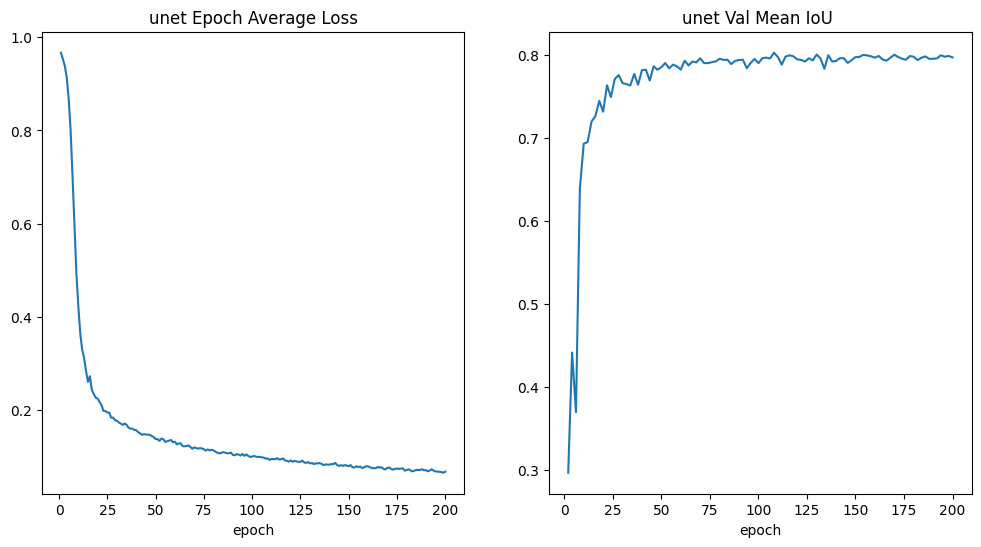

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 171MB/s]


Total number of parameters: 28513705
----------
epoch 1/200


Training: 100%|██████████| 121/121 [00:07<00:00, 15.84it/s]


epoch 1 average loss: 0.9713
----------
epoch 2/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.16it/s]


epoch 2 average loss: 0.6066


Validation: 100%|██████████| 61/61 [00:02<00:00, 30.33it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.5465
best mean IoU: 0.5465 at epoch: 2
----------
epoch 3/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.97it/s]


epoch 3 average loss: 0.3802
----------
epoch 4/200


Training: 100%|██████████| 121/121 [00:08<00:00, 14.70it/s]


epoch 4 average loss: 0.3339


Validation: 100%|██████████| 61/61 [00:02<00:00, 28.46it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.6210
best mean IoU: 0.6210 at epoch: 4
----------
epoch 5/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.88it/s]


epoch 5 average loss: 0.3175
----------
epoch 6/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.02it/s]


epoch 6 average loss: 0.2942


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.49it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.6388
best mean IoU: 0.6388 at epoch: 6
----------
epoch 7/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.48it/s]


epoch 7 average loss: 0.2885
----------
epoch 8/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.32it/s]


epoch 8 average loss: 0.2705


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.83it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.6635
best mean IoU: 0.6635 at epoch: 8
----------
epoch 9/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.35it/s]


epoch 9 average loss: 0.2544
----------
epoch 10/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.40it/s]


epoch 10 average loss: 0.2539


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.69it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.6690
best mean IoU: 0.6690 at epoch: 10
----------
epoch 11/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.46it/s]


epoch 11 average loss: 0.2426
----------
epoch 12/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.47it/s]


epoch 12 average loss: 0.2347


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.45it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.6849
best mean IoU: 0.6849 at epoch: 12
----------
epoch 13/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.70it/s]


epoch 13 average loss: 0.2263
----------
epoch 14/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.54it/s]


epoch 14 average loss: 0.2237


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.93it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.6877
best mean IoU: 0.6877 at epoch: 14
----------
epoch 15/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.85it/s]


epoch 15 average loss: 0.2164
----------
epoch 16/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 16 average loss: 0.2156


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.74it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.6920
best mean IoU: 0.6920 at epoch: 16
----------
epoch 17/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.18it/s]


epoch 17 average loss: 0.2084
----------
epoch 18/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.29it/s]


epoch 18 average loss: 0.2037


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.91it/s]


saved new best metric model
current epoch: 18 current mean IoU: 0.7020
best mean IoU: 0.7020 at epoch: 18
----------
epoch 19/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.76it/s]


epoch 19 average loss: 0.2006
----------
epoch 20/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.64it/s]


epoch 20 average loss: 0.1996


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.80it/s]


current epoch: 20 current mean IoU: 0.6983
best mean IoU: 0.7020 at epoch: 18
----------
epoch 21/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.84it/s]


epoch 21 average loss: 0.2011
----------
epoch 22/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.90it/s]


epoch 22 average loss: 0.1937


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.81it/s]


saved new best metric model
current epoch: 22 current mean IoU: 0.7020
best mean IoU: 0.7020 at epoch: 22
----------
epoch 23/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.91it/s]


epoch 23 average loss: 0.1906
----------
epoch 24/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.04it/s]


epoch 24 average loss: 0.1831


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.42it/s]


saved new best metric model
current epoch: 24 current mean IoU: 0.7057
best mean IoU: 0.7057 at epoch: 24
----------
epoch 25/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.55it/s]


epoch 25 average loss: 0.1814
----------
epoch 26/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.33it/s]


epoch 26 average loss: 0.1822


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.94it/s]


current epoch: 26 current mean IoU: 0.7054
best mean IoU: 0.7057 at epoch: 24
----------
epoch 27/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.64it/s]


epoch 27 average loss: 0.1800
----------
epoch 28/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.14it/s]


epoch 28 average loss: 0.1734


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.68it/s]


saved new best metric model
current epoch: 28 current mean IoU: 0.7139
best mean IoU: 0.7139 at epoch: 28
----------
epoch 29/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 29 average loss: 0.1735
----------
epoch 30/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.68it/s]


epoch 30 average loss: 0.1693


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.40it/s]


saved new best metric model
current epoch: 30 current mean IoU: 0.7154
best mean IoU: 0.7154 at epoch: 30
----------
epoch 31/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.86it/s]


epoch 31 average loss: 0.1645
----------
epoch 32/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.79it/s]


epoch 32 average loss: 0.1618


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.48it/s]


current epoch: 32 current mean IoU: 0.7123
best mean IoU: 0.7154 at epoch: 30
----------
epoch 33/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.27it/s]


epoch 33 average loss: 0.1622
----------
epoch 34/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.12it/s]


epoch 34 average loss: 0.1627


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.32it/s]


saved new best metric model
current epoch: 34 current mean IoU: 0.7180
best mean IoU: 0.7180 at epoch: 34
----------
epoch 35/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.17it/s]


epoch 35 average loss: 0.1577
----------
epoch 36/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.02it/s]


epoch 36 average loss: 0.1582


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.18it/s]


saved new best metric model
current epoch: 36 current mean IoU: 0.7205
best mean IoU: 0.7205 at epoch: 36
----------
epoch 37/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.24it/s]


epoch 37 average loss: 0.1547
----------
epoch 38/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.05it/s]


epoch 38 average loss: 0.1526


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.73it/s]


saved new best metric model
current epoch: 38 current mean IoU: 0.7219
best mean IoU: 0.7219 at epoch: 38
----------
epoch 39/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.83it/s]


epoch 39 average loss: 0.1503
----------
epoch 40/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.37it/s]


epoch 40 average loss: 0.1523


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.40it/s]


saved new best metric model
current epoch: 40 current mean IoU: 0.7250
best mean IoU: 0.7250 at epoch: 40
----------
epoch 41/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.23it/s]


epoch 41 average loss: 0.1484
----------
epoch 42/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.31it/s]


epoch 42 average loss: 0.1472


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.86it/s]


saved new best metric model
current epoch: 42 current mean IoU: 0.7287
best mean IoU: 0.7287 at epoch: 42
----------
epoch 43/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 43 average loss: 0.1426
----------
epoch 44/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.04it/s]


epoch 44 average loss: 0.1426


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.35it/s]


current epoch: 44 current mean IoU: 0.7278
best mean IoU: 0.7287 at epoch: 42
----------
epoch 45/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 45 average loss: 0.1417
----------
epoch 46/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.61it/s]


epoch 46 average loss: 0.1408


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.47it/s]


current epoch: 46 current mean IoU: 0.7223
best mean IoU: 0.7287 at epoch: 42
----------
epoch 47/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 47 average loss: 0.1426
----------
epoch 48/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.98it/s]


epoch 48 average loss: 0.1402


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.32it/s]


saved new best metric model
current epoch: 48 current mean IoU: 0.7301
best mean IoU: 0.7301 at epoch: 48
----------
epoch 49/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.24it/s]


epoch 49 average loss: 0.1392
----------
epoch 50/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.06it/s]


epoch 50 average loss: 0.1365


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.42it/s]


current epoch: 50 current mean IoU: 0.7299
best mean IoU: 0.7301 at epoch: 48
----------
epoch 51/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.36it/s]


epoch 51 average loss: 0.1373
----------
epoch 52/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.00it/s]


epoch 52 average loss: 0.1333


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.01it/s]


current epoch: 52 current mean IoU: 0.7261
best mean IoU: 0.7301 at epoch: 48
----------
epoch 53/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.05it/s]


epoch 53 average loss: 0.1341
----------
epoch 54/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.71it/s]


epoch 54 average loss: 0.1323


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.30it/s]


saved new best metric model
current epoch: 54 current mean IoU: 0.7326
best mean IoU: 0.7326 at epoch: 54
----------
epoch 55/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.11it/s]


epoch 55 average loss: 0.1320
----------
epoch 56/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.61it/s]


epoch 56 average loss: 0.1283


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.20it/s]


current epoch: 56 current mean IoU: 0.7304
best mean IoU: 0.7326 at epoch: 54
----------
epoch 57/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.36it/s]


epoch 57 average loss: 0.1290
----------
epoch 58/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.21it/s]


epoch 58 average loss: 0.1274


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.64it/s]


current epoch: 58 current mean IoU: 0.7318
best mean IoU: 0.7326 at epoch: 54
----------
epoch 59/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.45it/s]


epoch 59 average loss: 0.1270
----------
epoch 60/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.74it/s]


epoch 60 average loss: 0.1256


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.38it/s]


saved new best metric model
current epoch: 60 current mean IoU: 0.7352
best mean IoU: 0.7352 at epoch: 60
----------
epoch 61/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.86it/s]


epoch 61 average loss: 0.1250
----------
epoch 62/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.28it/s]


epoch 62 average loss: 0.1236


Validation: 100%|██████████| 61/61 [00:01<00:00, 34.10it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.7373
best mean IoU: 0.7373 at epoch: 62
----------
epoch 63/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.43it/s]


epoch 63 average loss: 0.1242
----------
epoch 64/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.67it/s]


epoch 64 average loss: 0.1251


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.27it/s]


current epoch: 64 current mean IoU: 0.7363
best mean IoU: 0.7373 at epoch: 62
----------
epoch 65/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.96it/s]


epoch 65 average loss: 0.1229
----------
epoch 66/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.95it/s]


epoch 66 average loss: 0.1208


Validation: 100%|██████████| 61/61 [00:01<00:00, 34.98it/s]


saved new best metric model
current epoch: 66 current mean IoU: 0.7406
best mean IoU: 0.7406 at epoch: 66
----------
epoch 67/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.03it/s]


epoch 67 average loss: 0.1198
----------
epoch 68/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.60it/s]


epoch 68 average loss: 0.1188


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.64it/s]


current epoch: 68 current mean IoU: 0.7362
best mean IoU: 0.7406 at epoch: 66
----------
epoch 69/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.11it/s]


epoch 69 average loss: 0.1221
----------
epoch 70/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.20it/s]


epoch 70 average loss: 0.1197


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.19it/s]


current epoch: 70 current mean IoU: 0.7390
best mean IoU: 0.7406 at epoch: 66
----------
epoch 71/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.95it/s]


epoch 71 average loss: 0.1175
----------
epoch 72/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.17it/s]


epoch 72 average loss: 0.1148


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.28it/s]


saved new best metric model
current epoch: 72 current mean IoU: 0.7417
best mean IoU: 0.7417 at epoch: 72
----------
epoch 73/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.95it/s]


epoch 73 average loss: 0.1156
----------
epoch 74/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.08it/s]


epoch 74 average loss: 0.1174


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.02it/s]


saved new best metric model
current epoch: 74 current mean IoU: 0.7419
best mean IoU: 0.7419 at epoch: 74
----------
epoch 75/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.02it/s]


epoch 75 average loss: 0.1158
----------
epoch 76/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.52it/s]


epoch 76 average loss: 0.1145


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.44it/s]


saved new best metric model
current epoch: 76 current mean IoU: 0.7432
best mean IoU: 0.7432 at epoch: 76
----------
epoch 77/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.81it/s]


epoch 77 average loss: 0.1132
----------
epoch 78/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 78 average loss: 0.1104


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.41it/s]


current epoch: 78 current mean IoU: 0.7389
best mean IoU: 0.7432 at epoch: 76
----------
epoch 79/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.80it/s]


epoch 79 average loss: 0.1120
----------
epoch 80/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.02it/s]


epoch 80 average loss: 0.1093


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.55it/s]


current epoch: 80 current mean IoU: 0.7368
best mean IoU: 0.7432 at epoch: 76
----------
epoch 81/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.71it/s]


epoch 81 average loss: 0.1094
----------
epoch 82/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.07it/s]


epoch 82 average loss: 0.1095


Validation: 100%|██████████| 61/61 [00:01<00:00, 34.93it/s]


saved new best metric model
current epoch: 82 current mean IoU: 0.7448
best mean IoU: 0.7448 at epoch: 82
----------
epoch 83/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.62it/s]


epoch 83 average loss: 0.1143
----------
epoch 84/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.69it/s]


epoch 84 average loss: 0.1120


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.46it/s]


current epoch: 84 current mean IoU: 0.7443
best mean IoU: 0.7448 at epoch: 82
----------
epoch 85/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.83it/s]


epoch 85 average loss: 0.1093
----------
epoch 86/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.28it/s]


epoch 86 average loss: 0.1100


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.10it/s]


current epoch: 86 current mean IoU: 0.7418
best mean IoU: 0.7448 at epoch: 82
----------
epoch 87/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.99it/s]


epoch 87 average loss: 0.1074
----------
epoch 88/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.85it/s]


epoch 88 average loss: 0.1063


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.02it/s]


saved new best metric model
current epoch: 88 current mean IoU: 0.7453
best mean IoU: 0.7453 at epoch: 88
----------
epoch 89/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.38it/s]


epoch 89 average loss: 0.1053
----------
epoch 90/200


Training: 100%|██████████| 121/121 [00:07<00:00, 16.22it/s]


epoch 90 average loss: 0.1067


Validation: 100%|██████████| 61/61 [00:01<00:00, 34.71it/s]


saved new best metric model
current epoch: 90 current mean IoU: 0.7490
best mean IoU: 0.7490 at epoch: 90
----------
epoch 91/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.76it/s]


epoch 91 average loss: 0.1081
----------
epoch 92/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.15it/s]


epoch 92 average loss: 0.1060


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.65it/s]


current epoch: 92 current mean IoU: 0.7420
best mean IoU: 0.7490 at epoch: 90
----------
epoch 93/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.16it/s]


epoch 93 average loss: 0.1044
----------
epoch 94/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.97it/s]


epoch 94 average loss: 0.1031


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.30it/s]


current epoch: 94 current mean IoU: 0.7454
best mean IoU: 0.7490 at epoch: 90
----------
epoch 95/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.71it/s]


epoch 95 average loss: 0.1049
----------
epoch 96/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.05it/s]


epoch 96 average loss: 0.1024


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.93it/s]


current epoch: 96 current mean IoU: 0.7460
best mean IoU: 0.7490 at epoch: 90
----------
epoch 97/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.70it/s]


epoch 97 average loss: 0.1028
----------
epoch 98/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.81it/s]


epoch 98 average loss: 0.1024


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.88it/s]


current epoch: 98 current mean IoU: 0.7485
best mean IoU: 0.7490 at epoch: 90
----------
epoch 99/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.01it/s]


epoch 99 average loss: 0.0997
----------
epoch 100/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.97it/s]


epoch 100 average loss: 0.1014


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.35it/s]


current epoch: 100 current mean IoU: 0.7419
best mean IoU: 0.7490 at epoch: 90
----------
epoch 101/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.02it/s]


epoch 101 average loss: 0.1017
----------
epoch 102/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.90it/s]


epoch 102 average loss: 0.1020


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.24it/s]


saved new best metric model
current epoch: 102 current mean IoU: 0.7510
best mean IoU: 0.7510 at epoch: 102
----------
epoch 103/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.97it/s]


epoch 103 average loss: 0.0997
----------
epoch 104/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.80it/s]


epoch 104 average loss: 0.0992


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.84it/s]


current epoch: 104 current mean IoU: 0.7478
best mean IoU: 0.7510 at epoch: 102
----------
epoch 105/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.63it/s]


epoch 105 average loss: 0.1006
----------
epoch 106/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.79it/s]


epoch 106 average loss: 0.1038


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.00it/s]


current epoch: 106 current mean IoU: 0.7491
best mean IoU: 0.7510 at epoch: 102
----------
epoch 107/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 107 average loss: 0.1007
----------
epoch 108/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 108 average loss: 0.1028


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.75it/s]


current epoch: 108 current mean IoU: 0.7471
best mean IoU: 0.7510 at epoch: 102
----------
epoch 109/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.27it/s]


epoch 109 average loss: 0.0997
----------
epoch 110/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.19it/s]


epoch 110 average loss: 0.0967


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.74it/s]


current epoch: 110 current mean IoU: 0.7507
best mean IoU: 0.7510 at epoch: 102
----------
epoch 111/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 111 average loss: 0.0970
----------
epoch 112/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.92it/s]


epoch 112 average loss: 0.0949


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.68it/s]


current epoch: 112 current mean IoU: 0.7483
best mean IoU: 0.7510 at epoch: 102
----------
epoch 113/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.00it/s]


epoch 113 average loss: 0.0969
----------
epoch 114/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.85it/s]


epoch 114 average loss: 0.0951


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.29it/s]


current epoch: 114 current mean IoU: 0.7488
best mean IoU: 0.7510 at epoch: 102
----------
epoch 115/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.83it/s]


epoch 115 average loss: 0.0975
----------
epoch 116/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.47it/s]


epoch 116 average loss: 0.0995


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.35it/s]


current epoch: 116 current mean IoU: 0.7497
best mean IoU: 0.7510 at epoch: 102
----------
epoch 117/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.35it/s]


epoch 117 average loss: 0.0967
----------
epoch 118/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.80it/s]


epoch 118 average loss: 0.0930


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.34it/s]


saved new best metric model
current epoch: 118 current mean IoU: 0.7522
best mean IoU: 0.7522 at epoch: 118
----------
epoch 119/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.00it/s]


epoch 119 average loss: 0.0954
----------
epoch 120/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.69it/s]


epoch 120 average loss: 0.0968


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.94it/s]


current epoch: 120 current mean IoU: 0.7478
best mean IoU: 0.7522 at epoch: 118
----------
epoch 121/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.70it/s]


epoch 121 average loss: 0.0988
----------
epoch 122/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.03it/s]


epoch 122 average loss: 0.0932


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.01it/s]


current epoch: 122 current mean IoU: 0.7504
best mean IoU: 0.7522 at epoch: 118
----------
epoch 123/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.03it/s]


epoch 123 average loss: 0.0903
----------
epoch 124/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.85it/s]


epoch 124 average loss: 0.0956


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.66it/s]


current epoch: 124 current mean IoU: 0.7507
best mean IoU: 0.7522 at epoch: 118
----------
epoch 125/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.56it/s]


epoch 125 average loss: 0.0932
----------
epoch 126/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.87it/s]


epoch 126 average loss: 0.0904


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.93it/s]


current epoch: 126 current mean IoU: 0.7473
best mean IoU: 0.7522 at epoch: 118
----------
epoch 127/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.15it/s]


epoch 127 average loss: 0.0924
----------
epoch 128/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.80it/s]


epoch 128 average loss: 0.0931


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.99it/s]


current epoch: 128 current mean IoU: 0.7519
best mean IoU: 0.7522 at epoch: 118
----------
epoch 129/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.86it/s]


epoch 129 average loss: 0.0906
----------
epoch 130/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.01it/s]


epoch 130 average loss: 0.0895


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.56it/s]


saved new best metric model
current epoch: 130 current mean IoU: 0.7557
best mean IoU: 0.7557 at epoch: 130
----------
epoch 131/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.74it/s]


epoch 131 average loss: 0.0923
----------
epoch 132/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.75it/s]


epoch 132 average loss: 0.0918


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.83it/s]


current epoch: 132 current mean IoU: 0.7529
best mean IoU: 0.7557 at epoch: 130
----------
epoch 133/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 133 average loss: 0.0928
----------
epoch 134/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.89it/s]


epoch 134 average loss: 0.0913


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.83it/s]


current epoch: 134 current mean IoU: 0.7550
best mean IoU: 0.7557 at epoch: 130
----------
epoch 135/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.87it/s]


epoch 135 average loss: 0.0894
----------
epoch 136/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.94it/s]


epoch 136 average loss: 0.0887


Validation: 100%|██████████| 61/61 [00:01<00:00, 33.82it/s]


current epoch: 136 current mean IoU: 0.7531
best mean IoU: 0.7557 at epoch: 130
----------
epoch 137/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.61it/s]


epoch 137 average loss: 0.0895
----------
epoch 138/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.35it/s]


epoch 138 average loss: 0.0885


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.58it/s]


saved new best metric model
current epoch: 138 current mean IoU: 0.7557
best mean IoU: 0.7557 at epoch: 138
----------
epoch 139/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.50it/s]


epoch 139 average loss: 0.0896
----------
epoch 140/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.42it/s]


epoch 140 average loss: 0.0891


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.01it/s]


saved new best metric model
current epoch: 140 current mean IoU: 0.7568
best mean IoU: 0.7568 at epoch: 140
----------
epoch 141/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.14it/s]


epoch 141 average loss: 0.0891
----------
epoch 142/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


epoch 142 average loss: 0.0900


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.67it/s]


current epoch: 142 current mean IoU: 0.7536
best mean IoU: 0.7568 at epoch: 140
----------
epoch 143/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.16it/s]


epoch 143 average loss: 0.0858
----------
epoch 144/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.46it/s]


epoch 144 average loss: 0.0875


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.22it/s]


current epoch: 144 current mean IoU: 0.7471
best mean IoU: 0.7568 at epoch: 140
----------
epoch 145/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.49it/s]


epoch 145 average loss: 0.0891
----------
epoch 146/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.06it/s]


epoch 146 average loss: 0.0864


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.24it/s]


saved new best metric model
current epoch: 146 current mean IoU: 0.7568
best mean IoU: 0.7568 at epoch: 146
----------
epoch 147/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.60it/s]


epoch 147 average loss: 0.0887
----------
epoch 148/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.54it/s]


epoch 148 average loss: 0.0855


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.53it/s]


current epoch: 148 current mean IoU: 0.7522
best mean IoU: 0.7568 at epoch: 146
----------
epoch 149/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.98it/s]


epoch 149 average loss: 0.0865
----------
epoch 150/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.70it/s]


epoch 150 average loss: 0.0833


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.35it/s]


saved new best metric model
current epoch: 150 current mean IoU: 0.7601
best mean IoU: 0.7601 at epoch: 150
----------
epoch 151/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.59it/s]


epoch 151 average loss: 0.0843
----------
epoch 152/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.60it/s]


epoch 152 average loss: 0.0843


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.77it/s]


current epoch: 152 current mean IoU: 0.7595
best mean IoU: 0.7601 at epoch: 150
----------
epoch 153/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.41it/s]


epoch 153 average loss: 0.0841
----------
epoch 154/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


epoch 154 average loss: 0.0861


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.94it/s]


current epoch: 154 current mean IoU: 0.7561
best mean IoU: 0.7601 at epoch: 150
----------
epoch 155/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.80it/s]


epoch 155 average loss: 0.0845
----------
epoch 156/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.92it/s]


epoch 156 average loss: 0.0853


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.98it/s]


current epoch: 156 current mean IoU: 0.7544
best mean IoU: 0.7601 at epoch: 150
----------
epoch 157/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.97it/s]


epoch 157 average loss: 0.0841
----------
epoch 158/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.22it/s]


epoch 158 average loss: 0.0837


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.87it/s]


current epoch: 158 current mean IoU: 0.7516
best mean IoU: 0.7601 at epoch: 150
----------
epoch 159/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.67it/s]


epoch 159 average loss: 0.0833
----------
epoch 160/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.09it/s]


epoch 160 average loss: 0.0831


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.71it/s]


current epoch: 160 current mean IoU: 0.7576
best mean IoU: 0.7601 at epoch: 150
----------
epoch 161/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.85it/s]


epoch 161 average loss: 0.0828
----------
epoch 162/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.89it/s]


epoch 162 average loss: 0.0835


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.06it/s]


current epoch: 162 current mean IoU: 0.7560
best mean IoU: 0.7601 at epoch: 150
----------
epoch 163/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.75it/s]


epoch 163 average loss: 0.0808
----------
epoch 164/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.34it/s]


epoch 164 average loss: 0.0840


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.26it/s]


current epoch: 164 current mean IoU: 0.7564
best mean IoU: 0.7601 at epoch: 150
----------
epoch 165/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.74it/s]


epoch 165 average loss: 0.0848
----------
epoch 166/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.62it/s]


epoch 166 average loss: 0.0814


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.58it/s]


current epoch: 166 current mean IoU: 0.7566
best mean IoU: 0.7601 at epoch: 150
----------
epoch 167/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.92it/s]


epoch 167 average loss: 0.0804
----------
epoch 168/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.98it/s]


epoch 168 average loss: 0.0833


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.23it/s]


current epoch: 168 current mean IoU: 0.7569
best mean IoU: 0.7601 at epoch: 150
----------
epoch 169/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.78it/s]


epoch 169 average loss: 0.0826
----------
epoch 170/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.09it/s]


epoch 170 average loss: 0.0819


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.43it/s]


current epoch: 170 current mean IoU: 0.7563
best mean IoU: 0.7601 at epoch: 150
----------
epoch 171/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.23it/s]


epoch 171 average loss: 0.0812
----------
epoch 172/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.81it/s]


epoch 172 average loss: 0.0790


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.71it/s]


current epoch: 172 current mean IoU: 0.7577
best mean IoU: 0.7601 at epoch: 150
----------
epoch 173/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.07it/s]


epoch 173 average loss: 0.0797
----------
epoch 174/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.82it/s]


epoch 174 average loss: 0.0791


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.13it/s]


current epoch: 174 current mean IoU: 0.7570
best mean IoU: 0.7601 at epoch: 150
----------
epoch 175/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.48it/s]


epoch 175 average loss: 0.0800
----------
epoch 176/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.29it/s]


epoch 176 average loss: 0.0812


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.63it/s]


current epoch: 176 current mean IoU: 0.7551
best mean IoU: 0.7601 at epoch: 150
----------
epoch 177/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.74it/s]


epoch 177 average loss: 0.0825
----------
epoch 178/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.66it/s]


epoch 178 average loss: 0.0822


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.54it/s]


current epoch: 178 current mean IoU: 0.7589
best mean IoU: 0.7601 at epoch: 150
----------
epoch 179/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.76it/s]


epoch 179 average loss: 0.0826
----------
epoch 180/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.22it/s]


epoch 180 average loss: 0.0825


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.97it/s]


current epoch: 180 current mean IoU: 0.7588
best mean IoU: 0.7601 at epoch: 150
----------
epoch 181/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.14it/s]


epoch 181 average loss: 0.0803
----------
epoch 182/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.66it/s]


epoch 182 average loss: 0.0807


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.34it/s]


current epoch: 182 current mean IoU: 0.7562
best mean IoU: 0.7601 at epoch: 150
----------
epoch 183/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.77it/s]


epoch 183 average loss: 0.0762
----------
epoch 184/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.31it/s]


epoch 184 average loss: 0.0796


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.06it/s]


current epoch: 184 current mean IoU: 0.7559
best mean IoU: 0.7601 at epoch: 150
----------
epoch 185/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.38it/s]


epoch 185 average loss: 0.0803
----------
epoch 186/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.16it/s]


epoch 186 average loss: 0.0757


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.34it/s]


current epoch: 186 current mean IoU: 0.7569
best mean IoU: 0.7601 at epoch: 150
----------
epoch 187/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.09it/s]


epoch 187 average loss: 0.0771
----------
epoch 188/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.54it/s]


epoch 188 average loss: 0.0785


Validation: 100%|██████████| 61/61 [00:01<00:00, 37.09it/s]


current epoch: 188 current mean IoU: 0.7577
best mean IoU: 0.7601 at epoch: 150
----------
epoch 189/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.84it/s]


epoch 189 average loss: 0.0771
----------
epoch 190/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.38it/s]


epoch 190 average loss: 0.0800


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.76it/s]


current epoch: 190 current mean IoU: 0.7557
best mean IoU: 0.7601 at epoch: 150
----------
epoch 191/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.82it/s]


epoch 191 average loss: 0.0773
----------
epoch 192/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.76it/s]


epoch 192 average loss: 0.0787


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.51it/s]


current epoch: 192 current mean IoU: 0.7535
best mean IoU: 0.7601 at epoch: 150
----------
epoch 193/200


Training: 100%|██████████| 121/121 [00:07<00:00, 17.26it/s]


epoch 193 average loss: 0.0780
----------
epoch 194/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.62it/s]


epoch 194 average loss: 0.0743


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.14it/s]


current epoch: 194 current mean IoU: 0.7577
best mean IoU: 0.7601 at epoch: 150
----------
epoch 195/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.16it/s]


epoch 195 average loss: 0.0760
----------
epoch 196/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.85it/s]


epoch 196 average loss: 0.0760


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.59it/s]


saved new best metric model
current epoch: 196 current mean IoU: 0.7611
best mean IoU: 0.7611 at epoch: 196
----------
epoch 197/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.51it/s]


epoch 197 average loss: 0.0776
----------
epoch 198/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.44it/s]


epoch 198 average loss: 0.0774


Validation: 100%|██████████| 61/61 [00:01<00:00, 35.40it/s]


current epoch: 198 current mean IoU: 0.7549
best mean IoU: 0.7611 at epoch: 196
----------
epoch 199/200


Training: 100%|██████████| 121/121 [00:06<00:00, 18.03it/s]


epoch 199 average loss: 0.0763
----------
epoch 200/200


Training: 100%|██████████| 121/121 [00:06<00:00, 17.46it/s]


epoch 200 average loss: 0.0755


Validation: 100%|██████████| 61/61 [00:01<00:00, 36.80it/s]


current epoch: 200 current mean IoU: 0.7558
best mean IoU: 0.7611 at epoch: 196


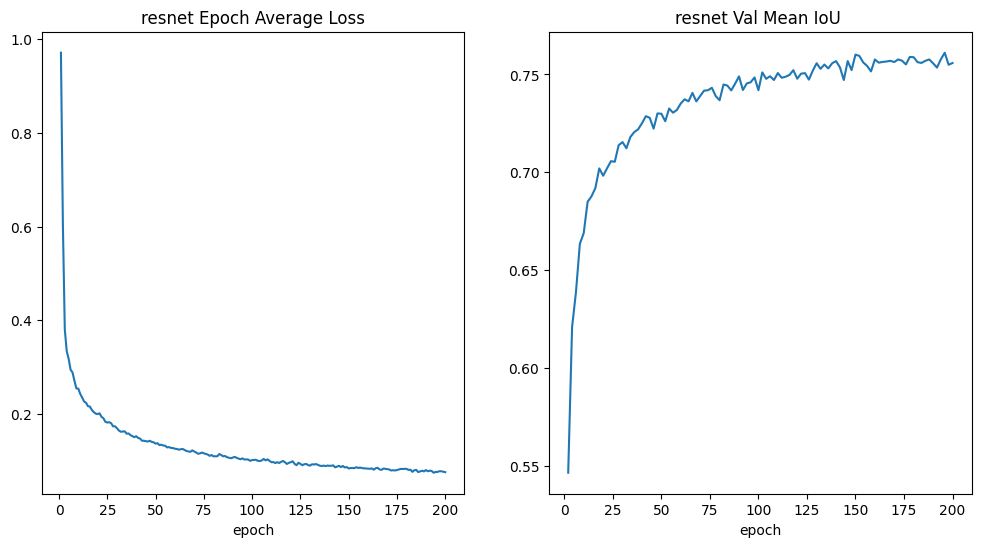

config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of parameters: 3714401
----------
epoch 1/200


Training: 100%|██████████| 121/121 [00:11<00:00, 10.40it/s]


epoch 1 average loss: 0.9718
----------
epoch 2/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.27it/s]


epoch 2 average loss: 0.8882


Validation: 100%|██████████| 61/61 [00:02<00:00, 21.02it/s]


saved new best metric model
current epoch: 2 current mean IoU: 0.4256
best mean IoU: 0.4256 at epoch: 2
----------
epoch 3/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.98it/s]


epoch 3 average loss: 0.6342
----------
epoch 4/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.10it/s]


epoch 4 average loss: 0.4743


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.80it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.5396
best mean IoU: 0.5396 at epoch: 4
----------
epoch 5/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 5 average loss: 0.4201
----------
epoch 6/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.22it/s]


epoch 6 average loss: 0.3786


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.01it/s]


saved new best metric model
current epoch: 6 current mean IoU: 0.5969
best mean IoU: 0.5969 at epoch: 6
----------
epoch 7/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.22it/s]


epoch 7 average loss: 0.3537
----------
epoch 8/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 8 average loss: 0.3417


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.13it/s]


saved new best metric model
current epoch: 8 current mean IoU: 0.6151
best mean IoU: 0.6151 at epoch: 8
----------
epoch 9/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 9 average loss: 0.3297
----------
epoch 10/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.30it/s]


epoch 10 average loss: 0.3253


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.47it/s]


saved new best metric model
current epoch: 10 current mean IoU: 0.6265
best mean IoU: 0.6265 at epoch: 10
----------
epoch 11/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 11 average loss: 0.3164
----------
epoch 12/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.94it/s]


epoch 12 average loss: 0.3075


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.92it/s]


saved new best metric model
current epoch: 12 current mean IoU: 0.6371
best mean IoU: 0.6371 at epoch: 12
----------
epoch 13/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.20it/s]


epoch 13 average loss: 0.2966
----------
epoch 14/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.15it/s]


epoch 14 average loss: 0.2888


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.94it/s]


saved new best metric model
current epoch: 14 current mean IoU: 0.6399
best mean IoU: 0.6399 at epoch: 14
----------
epoch 15/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.27it/s]


epoch 15 average loss: 0.2892
----------
epoch 16/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 16 average loss: 0.2831


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.91it/s]


saved new best metric model
current epoch: 16 current mean IoU: 0.6563
best mean IoU: 0.6563 at epoch: 16
----------
epoch 17/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.97it/s]


epoch 17 average loss: 0.2852
----------
epoch 18/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.08it/s]


epoch 18 average loss: 0.2855


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.21it/s]


current epoch: 18 current mean IoU: 0.6540
best mean IoU: 0.6563 at epoch: 16
----------
epoch 19/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.14it/s]


epoch 19 average loss: 0.2751
----------
epoch 20/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.07it/s]


epoch 20 average loss: 0.2712


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.50it/s]


current epoch: 20 current mean IoU: 0.6510
best mean IoU: 0.6563 at epoch: 16
----------
epoch 21/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.11it/s]


epoch 21 average loss: 0.2679
----------
epoch 22/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.22it/s]


epoch 22 average loss: 0.2656


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.46it/s]


current epoch: 22 current mean IoU: 0.6502
best mean IoU: 0.6563 at epoch: 16
----------
epoch 23/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.16it/s]


epoch 23 average loss: 0.2608
----------
epoch 24/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 24 average loss: 0.2572


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.37it/s]


current epoch: 24 current mean IoU: 0.6405
best mean IoU: 0.6563 at epoch: 16
----------
epoch 25/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.84it/s]


epoch 25 average loss: 0.2669
----------
epoch 26/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.94it/s]


epoch 26 average loss: 0.2580


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.28it/s]


current epoch: 26 current mean IoU: 0.6509
best mean IoU: 0.6563 at epoch: 16
----------
epoch 27/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.12it/s]


epoch 27 average loss: 0.2583
----------
epoch 28/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.20it/s]


epoch 28 average loss: 0.2521


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.00it/s]


saved new best metric model
current epoch: 28 current mean IoU: 0.6812
best mean IoU: 0.6812 at epoch: 28
----------
epoch 29/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 29 average loss: 0.2487
----------
epoch 30/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.15it/s]


epoch 30 average loss: 0.2501


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.35it/s]


current epoch: 30 current mean IoU: 0.6783
best mean IoU: 0.6812 at epoch: 28
----------
epoch 31/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.99it/s]


epoch 31 average loss: 0.2502
----------
epoch 32/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 32 average loss: 0.2456


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.14it/s]


current epoch: 32 current mean IoU: 0.6760
best mean IoU: 0.6812 at epoch: 28
----------
epoch 33/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.22it/s]


epoch 33 average loss: 0.2456
----------
epoch 34/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.31it/s]


epoch 34 average loss: 0.2441


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.33it/s]


saved new best metric model
current epoch: 34 current mean IoU: 0.6864
best mean IoU: 0.6864 at epoch: 34
----------
epoch 35/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.20it/s]


epoch 35 average loss: 0.2434
----------
epoch 36/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.22it/s]


epoch 36 average loss: 0.2408


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.77it/s]


current epoch: 36 current mean IoU: 0.6847
best mean IoU: 0.6864 at epoch: 34
----------
epoch 37/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.21it/s]


epoch 37 average loss: 0.2385
----------
epoch 38/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.16it/s]


epoch 38 average loss: 0.2380


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.72it/s]


current epoch: 38 current mean IoU: 0.6813
best mean IoU: 0.6864 at epoch: 34
----------
epoch 39/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.21it/s]


epoch 39 average loss: 0.2358
----------
epoch 40/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.30it/s]


epoch 40 average loss: 0.2334


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.11it/s]


saved new best metric model
current epoch: 40 current mean IoU: 0.6881
best mean IoU: 0.6881 at epoch: 40
----------
epoch 41/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 41 average loss: 0.2349
----------
epoch 42/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.10it/s]


epoch 42 average loss: 0.2322


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.41it/s]


current epoch: 42 current mean IoU: 0.6826
best mean IoU: 0.6881 at epoch: 40
----------
epoch 43/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.16it/s]


epoch 43 average loss: 0.2284
----------
epoch 44/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 44 average loss: 0.2275


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.21it/s]


saved new best metric model
current epoch: 44 current mean IoU: 0.6901
best mean IoU: 0.6901 at epoch: 44
----------
epoch 45/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.07it/s]


epoch 45 average loss: 0.2290
----------
epoch 46/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.18it/s]


epoch 46 average loss: 0.2273


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.29it/s]


saved new best metric model
current epoch: 46 current mean IoU: 0.6912
best mean IoU: 0.6912 at epoch: 46
----------
epoch 47/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.17it/s]


epoch 47 average loss: 0.2271
----------
epoch 48/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 48 average loss: 0.2233


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.52it/s]


saved new best metric model
current epoch: 48 current mean IoU: 0.6927
best mean IoU: 0.6927 at epoch: 48
----------
epoch 49/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.15it/s]


epoch 49 average loss: 0.2217
----------
epoch 50/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.16it/s]


epoch 50 average loss: 0.2247


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.49it/s]


current epoch: 50 current mean IoU: 0.6914
best mean IoU: 0.6927 at epoch: 48
----------
epoch 51/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.89it/s]


epoch 51 average loss: 0.2187
----------
epoch 52/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.96it/s]


epoch 52 average loss: 0.2187


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.08it/s]


saved new best metric model
current epoch: 52 current mean IoU: 0.6982
best mean IoU: 0.6982 at epoch: 52
----------
epoch 53/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.04it/s]


epoch 53 average loss: 0.2198
----------
epoch 54/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.82it/s]


epoch 54 average loss: 0.2195


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.75it/s]


current epoch: 54 current mean IoU: 0.6959
best mean IoU: 0.6982 at epoch: 52
----------
epoch 55/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.92it/s]


epoch 55 average loss: 0.2206
----------
epoch 56/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.90it/s]


epoch 56 average loss: 0.2150


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.17it/s]


saved new best metric model
current epoch: 56 current mean IoU: 0.6993
best mean IoU: 0.6993 at epoch: 56
----------
epoch 57/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.10it/s]


epoch 57 average loss: 0.2157
----------
epoch 58/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.99it/s]


epoch 58 average loss: 0.2139


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.93it/s]


current epoch: 58 current mean IoU: 0.6977
best mean IoU: 0.6993 at epoch: 56
----------
epoch 59/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.12it/s]


epoch 59 average loss: 0.2157
----------
epoch 60/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.30it/s]


epoch 60 average loss: 0.2144


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.91it/s]


current epoch: 60 current mean IoU: 0.6985
best mean IoU: 0.6993 at epoch: 56
----------
epoch 61/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.07it/s]


epoch 61 average loss: 0.2158
----------
epoch 62/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 62 average loss: 0.2132


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.44it/s]


saved new best metric model
current epoch: 62 current mean IoU: 0.7011
best mean IoU: 0.7011 at epoch: 62
----------
epoch 63/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.15it/s]


epoch 63 average loss: 0.2125
----------
epoch 64/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 64 average loss: 0.2095


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.32it/s]


current epoch: 64 current mean IoU: 0.7006
best mean IoU: 0.7011 at epoch: 62
----------
epoch 65/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 65 average loss: 0.2089
----------
epoch 66/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.10it/s]


epoch 66 average loss: 0.2098


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.46it/s]


saved new best metric model
current epoch: 66 current mean IoU: 0.7014
best mean IoU: 0.7014 at epoch: 66
----------
epoch 67/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.25it/s]


epoch 67 average loss: 0.2070
----------
epoch 68/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 68 average loss: 0.2065


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.00it/s]


current epoch: 68 current mean IoU: 0.7007
best mean IoU: 0.7014 at epoch: 66
----------
epoch 69/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.91it/s]


epoch 69 average loss: 0.2071
----------
epoch 70/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.05it/s]


epoch 70 average loss: 0.2078


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.37it/s]


current epoch: 70 current mean IoU: 0.7008
best mean IoU: 0.7014 at epoch: 66
----------
epoch 71/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 71 average loss: 0.2027
----------
epoch 72/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.98it/s]


epoch 72 average loss: 0.2054


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.83it/s]


current epoch: 72 current mean IoU: 0.7012
best mean IoU: 0.7014 at epoch: 66
----------
epoch 73/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.10it/s]


epoch 73 average loss: 0.2046
----------
epoch 74/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.08it/s]


epoch 74 average loss: 0.2066


Validation: 100%|██████████| 61/61 [00:02<00:00, 25.79it/s]


saved new best metric model
current epoch: 74 current mean IoU: 0.7048
best mean IoU: 0.7048 at epoch: 74
----------
epoch 75/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.22it/s]


epoch 75 average loss: 0.2056
----------
epoch 76/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 76 average loss: 0.2030


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.75it/s]


current epoch: 76 current mean IoU: 0.7020
best mean IoU: 0.7048 at epoch: 74
----------
epoch 77/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 77 average loss: 0.2040
----------
epoch 78/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.64it/s]


epoch 78 average loss: 0.2005


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.54it/s]


saved new best metric model
current epoch: 78 current mean IoU: 0.7074
best mean IoU: 0.7074 at epoch: 78
----------
epoch 79/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.66it/s]


epoch 79 average loss: 0.2014
----------
epoch 80/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.89it/s]


epoch 80 average loss: 0.1986


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.53it/s]


current epoch: 80 current mean IoU: 0.7072
best mean IoU: 0.7074 at epoch: 78
----------
epoch 81/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.98it/s]


epoch 81 average loss: 0.1981
----------
epoch 82/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.01it/s]


epoch 82 average loss: 0.1997


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.08it/s]


current epoch: 82 current mean IoU: 0.7042
best mean IoU: 0.7074 at epoch: 78
----------
epoch 83/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.85it/s]


epoch 83 average loss: 0.1995
----------
epoch 84/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 84 average loss: 0.1981


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.87it/s]


current epoch: 84 current mean IoU: 0.7034
best mean IoU: 0.7074 at epoch: 78
----------
epoch 85/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.88it/s]


epoch 85 average loss: 0.1983
----------
epoch 86/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 86 average loss: 0.1953


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.46it/s]


saved new best metric model
current epoch: 86 current mean IoU: 0.7076
best mean IoU: 0.7076 at epoch: 86
----------
epoch 87/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.02it/s]


epoch 87 average loss: 0.1987
----------
epoch 88/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.91it/s]


epoch 88 average loss: 0.1948


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.36it/s]


saved new best metric model
current epoch: 88 current mean IoU: 0.7085
best mean IoU: 0.7085 at epoch: 88
----------
epoch 89/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.01it/s]


epoch 89 average loss: 0.1936
----------
epoch 90/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.16it/s]


epoch 90 average loss: 0.1958


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.69it/s]


current epoch: 90 current mean IoU: 0.7061
best mean IoU: 0.7085 at epoch: 88
----------
epoch 91/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.07it/s]


epoch 91 average loss: 0.1938
----------
epoch 92/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.96it/s]


epoch 92 average loss: 0.1956


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.99it/s]


current epoch: 92 current mean IoU: 0.7081
best mean IoU: 0.7085 at epoch: 88
----------
epoch 93/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.23it/s]


epoch 93 average loss: 0.1911
----------
epoch 94/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.00it/s]


epoch 94 average loss: 0.1941


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.85it/s]


current epoch: 94 current mean IoU: 0.7084
best mean IoU: 0.7085 at epoch: 88
----------
epoch 95/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.83it/s]


epoch 95 average loss: 0.1953
----------
epoch 96/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 96 average loss: 0.1940


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.25it/s]


current epoch: 96 current mean IoU: 0.7041
best mean IoU: 0.7085 at epoch: 88
----------
epoch 97/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.11it/s]


epoch 97 average loss: 0.1947
----------
epoch 98/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.17it/s]


epoch 98 average loss: 0.1907


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.82it/s]


current epoch: 98 current mean IoU: 0.7063
best mean IoU: 0.7085 at epoch: 88
----------
epoch 99/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.85it/s]


epoch 99 average loss: 0.1900
----------
epoch 100/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.12it/s]


epoch 100 average loss: 0.1895


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.22it/s]


current epoch: 100 current mean IoU: 0.7082
best mean IoU: 0.7085 at epoch: 88
----------
epoch 101/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.17it/s]


epoch 101 average loss: 0.1988
----------
epoch 102/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.82it/s]


epoch 102 average loss: 0.1917


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.72it/s]


saved new best metric model
current epoch: 102 current mean IoU: 0.7099
best mean IoU: 0.7099 at epoch: 102
----------
epoch 103/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 103 average loss: 0.1909
----------
epoch 104/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.35it/s]


epoch 104 average loss: 0.1882


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.39it/s]


saved new best metric model
current epoch: 104 current mean IoU: 0.7127
best mean IoU: 0.7127 at epoch: 104
----------
epoch 105/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.18it/s]


epoch 105 average loss: 0.1894
----------
epoch 106/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.24it/s]


epoch 106 average loss: 0.1882


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.87it/s]


current epoch: 106 current mean IoU: 0.7103
best mean IoU: 0.7127 at epoch: 104
----------
epoch 107/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 107 average loss: 0.1889
----------
epoch 108/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.16it/s]


epoch 108 average loss: 0.1880


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.19it/s]


current epoch: 108 current mean IoU: 0.7112
best mean IoU: 0.7127 at epoch: 104
----------
epoch 109/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.18it/s]


epoch 109 average loss: 0.1903
----------
epoch 110/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 110 average loss: 0.1877


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.84it/s]


current epoch: 110 current mean IoU: 0.7105
best mean IoU: 0.7127 at epoch: 104
----------
epoch 111/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.94it/s]


epoch 111 average loss: 0.1866
----------
epoch 112/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.10it/s]


epoch 112 average loss: 0.1858


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.14it/s]


current epoch: 112 current mean IoU: 0.7120
best mean IoU: 0.7127 at epoch: 104
----------
epoch 113/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.85it/s]


epoch 113 average loss: 0.1853
----------
epoch 114/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.15it/s]


epoch 114 average loss: 0.1900


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.18it/s]


current epoch: 114 current mean IoU: 0.7079
best mean IoU: 0.7127 at epoch: 104
----------
epoch 115/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.21it/s]


epoch 115 average loss: 0.1849
----------
epoch 116/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.08it/s]


epoch 116 average loss: 0.1878


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.46it/s]


saved new best metric model
current epoch: 116 current mean IoU: 0.7133
best mean IoU: 0.7133 at epoch: 116
----------
epoch 117/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.15it/s]


epoch 117 average loss: 0.1832
----------
epoch 118/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.26it/s]


epoch 118 average loss: 0.1839


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.39it/s]


current epoch: 118 current mean IoU: 0.7054
best mean IoU: 0.7133 at epoch: 116
----------
epoch 119/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.24it/s]


epoch 119 average loss: 0.1847
----------
epoch 120/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.01it/s]


epoch 120 average loss: 0.1848


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.11it/s]


current epoch: 120 current mean IoU: 0.7078
best mean IoU: 0.7133 at epoch: 116
----------
epoch 121/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 121 average loss: 0.1850
----------
epoch 122/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.05it/s]


epoch 122 average loss: 0.1826


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.55it/s]


current epoch: 122 current mean IoU: 0.7128
best mean IoU: 0.7133 at epoch: 116
----------
epoch 123/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 123 average loss: 0.1851
----------
epoch 124/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.02it/s]


epoch 124 average loss: 0.1848


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.24it/s]


current epoch: 124 current mean IoU: 0.7112
best mean IoU: 0.7133 at epoch: 116
----------
epoch 125/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 125 average loss: 0.1821
----------
epoch 126/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.02it/s]


epoch 126 average loss: 0.1840


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.77it/s]


current epoch: 126 current mean IoU: 0.7121
best mean IoU: 0.7133 at epoch: 116
----------
epoch 127/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.06it/s]


epoch 127 average loss: 0.1823
----------
epoch 128/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.08it/s]


epoch 128 average loss: 0.1810


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.03it/s]


current epoch: 128 current mean IoU: 0.7079
best mean IoU: 0.7133 at epoch: 116
----------
epoch 129/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.19it/s]


epoch 129 average loss: 0.1824
----------
epoch 130/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.07it/s]


epoch 130 average loss: 0.1818


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.71it/s]


current epoch: 130 current mean IoU: 0.7092
best mean IoU: 0.7133 at epoch: 116
----------
epoch 131/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.02it/s]


epoch 131 average loss: 0.1814
----------
epoch 132/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.91it/s]


epoch 132 average loss: 0.1806


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.10it/s]


current epoch: 132 current mean IoU: 0.7124
best mean IoU: 0.7133 at epoch: 116
----------
epoch 133/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 133 average loss: 0.1796
----------
epoch 134/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 134 average loss: 0.1792


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.78it/s]


current epoch: 134 current mean IoU: 0.7115
best mean IoU: 0.7133 at epoch: 116
----------
epoch 135/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 135 average loss: 0.1788
----------
epoch 136/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.02it/s]


epoch 136 average loss: 0.1783


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.63it/s]


current epoch: 136 current mean IoU: 0.7100
best mean IoU: 0.7133 at epoch: 116
----------
epoch 137/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.09it/s]


epoch 137 average loss: 0.1782
----------
epoch 138/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 138 average loss: 0.1812


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.07it/s]


current epoch: 138 current mean IoU: 0.7103
best mean IoU: 0.7133 at epoch: 116
----------
epoch 139/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.78it/s]


epoch 139 average loss: 0.1785
----------
epoch 140/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.84it/s]


epoch 140 average loss: 0.1793


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.20it/s]


saved new best metric model
current epoch: 140 current mean IoU: 0.7153
best mean IoU: 0.7153 at epoch: 140
----------
epoch 141/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.86it/s]


epoch 141 average loss: 0.1798
----------
epoch 142/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.14it/s]


epoch 142 average loss: 0.1792


Validation: 100%|██████████| 61/61 [00:02<00:00, 25.95it/s]


current epoch: 142 current mean IoU: 0.7135
best mean IoU: 0.7153 at epoch: 140
----------
epoch 143/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.81it/s]


epoch 143 average loss: 0.1774
----------
epoch 144/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.94it/s]


epoch 144 average loss: 0.1765


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.60it/s]


current epoch: 144 current mean IoU: 0.7148
best mean IoU: 0.7153 at epoch: 140
----------
epoch 145/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.02it/s]


epoch 145 average loss: 0.1778
----------
epoch 146/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.96it/s]


epoch 146 average loss: 0.1759


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.52it/s]


saved new best metric model
current epoch: 146 current mean IoU: 0.7156
best mean IoU: 0.7156 at epoch: 146
----------
epoch 147/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.95it/s]


epoch 147 average loss: 0.1778
----------
epoch 148/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.79it/s]


epoch 148 average loss: 0.1770


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.14it/s]


current epoch: 148 current mean IoU: 0.7125
best mean IoU: 0.7156 at epoch: 146
----------
epoch 149/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.90it/s]


epoch 149 average loss: 0.1742
----------
epoch 150/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.14it/s]


epoch 150 average loss: 0.1739


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.57it/s]


current epoch: 150 current mean IoU: 0.7116
best mean IoU: 0.7156 at epoch: 146
----------
epoch 151/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.85it/s]


epoch 151 average loss: 0.1756
----------
epoch 152/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.77it/s]


epoch 152 average loss: 0.1741


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.67it/s]


current epoch: 152 current mean IoU: 0.7138
best mean IoU: 0.7156 at epoch: 146
----------
epoch 153/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.13it/s]


epoch 153 average loss: 0.1743
----------
epoch 154/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.00it/s]


epoch 154 average loss: 0.1737


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.70it/s]


current epoch: 154 current mean IoU: 0.7127
best mean IoU: 0.7156 at epoch: 146
----------
epoch 155/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.97it/s]


epoch 155 average loss: 0.1727
----------
epoch 156/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.77it/s]


epoch 156 average loss: 0.1760


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.51it/s]


saved new best metric model
current epoch: 156 current mean IoU: 0.7158
best mean IoU: 0.7158 at epoch: 156
----------
epoch 157/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.81it/s]


epoch 157 average loss: 0.1711
----------
epoch 158/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.88it/s]


epoch 158 average loss: 0.1716


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.18it/s]


current epoch: 158 current mean IoU: 0.7128
best mean IoU: 0.7158 at epoch: 156
----------
epoch 159/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.83it/s]


epoch 159 average loss: 0.1721
----------
epoch 160/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.99it/s]


epoch 160 average loss: 0.1721


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.29it/s]


current epoch: 160 current mean IoU: 0.7149
best mean IoU: 0.7158 at epoch: 156
----------
epoch 161/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.95it/s]


epoch 161 average loss: 0.1726
----------
epoch 162/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.11it/s]


epoch 162 average loss: 0.1731


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.40it/s]


current epoch: 162 current mean IoU: 0.7099
best mean IoU: 0.7158 at epoch: 156
----------
epoch 163/200


Training: 100%|██████████| 121/121 [00:09<00:00, 12.25it/s]


epoch 163 average loss: 0.1724
----------
epoch 164/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.91it/s]


epoch 164 average loss: 0.1710


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.34it/s]


current epoch: 164 current mean IoU: 0.7129
best mean IoU: 0.7158 at epoch: 156
----------
epoch 165/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.77it/s]


epoch 165 average loss: 0.1734
----------
epoch 166/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.02it/s]


epoch 166 average loss: 0.1735


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.43it/s]


current epoch: 166 current mean IoU: 0.7115
best mean IoU: 0.7158 at epoch: 156
----------
epoch 167/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.91it/s]


epoch 167 average loss: 0.1730
----------
epoch 168/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.72it/s]


epoch 168 average loss: 0.1728


Validation: 100%|██████████| 61/61 [00:02<00:00, 27.07it/s]


saved new best metric model
current epoch: 168 current mean IoU: 0.7185
best mean IoU: 0.7185 at epoch: 168
----------
epoch 169/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.97it/s]


epoch 169 average loss: 0.1707
----------
epoch 170/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.81it/s]


epoch 170 average loss: 0.1745


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.76it/s]


current epoch: 170 current mean IoU: 0.7148
best mean IoU: 0.7185 at epoch: 168
----------
epoch 171/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.92it/s]


epoch 171 average loss: 0.1734
----------
epoch 172/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.66it/s]


epoch 172 average loss: 0.1719


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.66it/s]


saved new best metric model
current epoch: 172 current mean IoU: 0.7194
best mean IoU: 0.7194 at epoch: 172
----------
epoch 173/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.70it/s]


epoch 173 average loss: 0.1710
----------
epoch 174/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.41it/s]


epoch 174 average loss: 0.1700


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.08it/s]


current epoch: 174 current mean IoU: 0.7154
best mean IoU: 0.7194 at epoch: 172
----------
epoch 175/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.84it/s]


epoch 175 average loss: 0.1694
----------
epoch 176/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.95it/s]


epoch 176 average loss: 0.1688


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.18it/s]


current epoch: 176 current mean IoU: 0.7141
best mean IoU: 0.7194 at epoch: 172
----------
epoch 177/200


Training: 100%|██████████| 121/121 [00:11<00:00, 10.85it/s]


epoch 177 average loss: 0.1699
----------
epoch 178/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.85it/s]


epoch 178 average loss: 0.1701


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.23it/s]


current epoch: 178 current mean IoU: 0.7163
best mean IoU: 0.7194 at epoch: 172
----------
epoch 179/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.81it/s]


epoch 179 average loss: 0.1718
----------
epoch 180/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.85it/s]


epoch 180 average loss: 0.1730


Validation: 100%|██████████| 61/61 [00:02<00:00, 25.75it/s]


current epoch: 180 current mean IoU: 0.7159
best mean IoU: 0.7194 at epoch: 172
----------
epoch 181/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.71it/s]


epoch 181 average loss: 0.1695
----------
epoch 182/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.77it/s]


epoch 182 average loss: 0.1696


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.10it/s]


current epoch: 182 current mean IoU: 0.7146
best mean IoU: 0.7194 at epoch: 172
----------
epoch 183/200


Training: 100%|██████████| 121/121 [00:10<00:00, 12.03it/s]


epoch 183 average loss: 0.1687
----------
epoch 184/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.88it/s]


epoch 184 average loss: 0.1679


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.55it/s]


current epoch: 184 current mean IoU: 0.7162
best mean IoU: 0.7194 at epoch: 172
----------
epoch 185/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.67it/s]


epoch 185 average loss: 0.1696
----------
epoch 186/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.58it/s]


epoch 186 average loss: 0.1695


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.66it/s]


current epoch: 186 current mean IoU: 0.7128
best mean IoU: 0.7194 at epoch: 172
----------
epoch 187/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.76it/s]


epoch 187 average loss: 0.1675
----------
epoch 188/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.77it/s]


epoch 188 average loss: 0.1670


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.59it/s]


current epoch: 188 current mean IoU: 0.7186
best mean IoU: 0.7194 at epoch: 172
----------
epoch 189/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.99it/s]


epoch 189 average loss: 0.1695
----------
epoch 190/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.87it/s]


epoch 190 average loss: 0.1678


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.02it/s]


current epoch: 190 current mean IoU: 0.7179
best mean IoU: 0.7194 at epoch: 172
----------
epoch 191/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.93it/s]


epoch 191 average loss: 0.1682
----------
epoch 192/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.87it/s]


epoch 192 average loss: 0.1685


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.60it/s]


current epoch: 192 current mean IoU: 0.7176
best mean IoU: 0.7194 at epoch: 172
----------
epoch 193/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.97it/s]


epoch 193 average loss: 0.1678
----------
epoch 194/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.68it/s]


epoch 194 average loss: 0.1674


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.52it/s]


current epoch: 194 current mean IoU: 0.7191
best mean IoU: 0.7194 at epoch: 172
----------
epoch 195/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.92it/s]


epoch 195 average loss: 0.1681
----------
epoch 196/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.81it/s]


epoch 196 average loss: 0.1664


Validation: 100%|██████████| 61/61 [00:02<00:00, 26.51it/s]


current epoch: 196 current mean IoU: 0.7169
best mean IoU: 0.7194 at epoch: 172
----------
epoch 197/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.77it/s]


epoch 197 average loss: 0.1652
----------
epoch 198/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.80it/s]


epoch 198 average loss: 0.1665


Validation: 100%|██████████| 61/61 [00:02<00:00, 25.56it/s]


current epoch: 198 current mean IoU: 0.7179
best mean IoU: 0.7194 at epoch: 172
----------
epoch 199/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.85it/s]


epoch 199 average loss: 0.1672
----------
epoch 200/200


Training: 100%|██████████| 121/121 [00:10<00:00, 11.66it/s]


epoch 200 average loss: 0.1657


Validation: 100%|██████████| 61/61 [00:02<00:00, 25.88it/s]


current epoch: 200 current mean IoU: 0.7162
best mean IoU: 0.7194 at epoch: 172


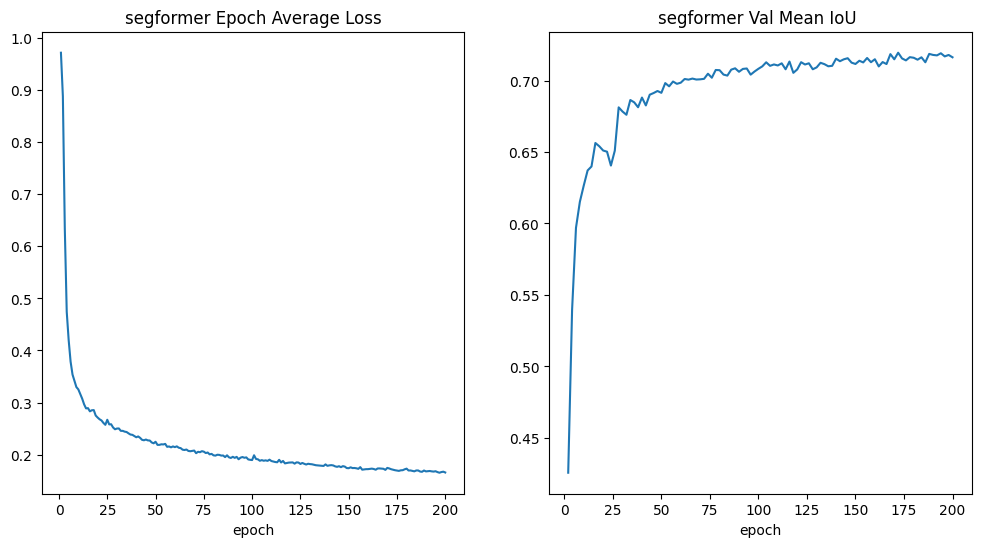

In [ ]:
for model_type in model_list:
    os.makedirs(os.path.join(root_dir, model_type), exist_ok=True)
    out_dir = os.path.join(root_dir, model_type)
    loss_values, metric_values = train_model(model_type, df_model_par, out_dir, loss_function, metric, device, lr=1e-4, attention_gate_flag=True)
    plot_train_curve(loss_values, metric_values, model_type, out_dir)

Testing

In [ ]:
test_loader = DataLoader(
    test_set, batch_size=8, num_workers=4
)

In [ ]:
model_list = ["resnet", "unet", "segformer", "custom"]
# model_list = ["custom", "unet"]

In [ ]:
def get_dice(pred, target):
    smooth = 1e-15
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [ ]:
mean_test_metric = pd.DataFrame(columns=['model_tye', 'mean_test_iou', 'mean_test_dice'])
plt.figure("check", (12, 6))
for j in range(len(model_list)):
    model_type = model_list[j]
    model = get_model(model_type, device, attention_gate_flag=True)
    model.load_state_dict(torch.load(os.path.join(root_dir, model_type, "best_metric_model.pth")))
    model.eval()
    test_metric_values = []
    test_dice_values = []
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):

            test_outputs = model(test_data["image"].to(device))
            test_labels = test_data["label"].to(device)
            if model_type == "segformer":
                test_outputs = torch.nn.functional.sigmoid(torch.nn.functional.interpolate(test_outputs.logits,128,mode="bilinear",align_corners=False))

            test_outputs = test_outputs.float() > 0.5
            iou = metric(test_outputs, test_labels)
            dice_val = get_dice(test_outputs, test_labels)
            test_metric_values.append(iou.item())
            test_dice_values.append(dice_val.item())


            # for j in range(10):
            if i >= 30 and i < 33:
                k = i - 30
                if j == 0:
                    plt.subplot(3, 6, 1 + 6 * k)
                    plt.title("original image")
                    plt.axis("off")
                    plt.imshow(test_data["image"][0, 0, :, :], cmap="gray")
                    plt.subplot(3, 6, 2 + 6 * k)
                    plt.title("label")
                    plt.axis("off")
                    plt.imshow(test_data["label"][0, 0, :, :])
                plt.subplot(3, 6, j + 3 + 6 * k)
                plt.title(f"{model_type} output")
                plt.axis("off")

                plt.imshow(test_outputs.detach().cpu()[0, 0, :, :])
    mean_test_metric.loc[j] = [model_type, sum(test_metric_values) / len(test_metric_values), sum(test_dice_values) / len(test_dice_values)]
plt.savefig(os.path.join(root_dir, f"model_comparison.png"))
plt.show()


In [ ]:
mean_test_metric

,model_tye,mean_test_iou,mean_test_dice
0,resnet,0.754830,0.856535
1,unet,0.795464,0.883350
2,segformer,0.723528,0.834092
3,custom,0.768039,0.865643


In [ ]:
df_model_par['parameters_num_millions'] = df_model_par['parameters_num'] / 1_000_000

In [ ]:
df_model_par

,model_type,parameters_num,parameters_num_millions
0,resnet,24436369,24.436369
1,unet,7763041,7.763041
2,segformer,3714401,3.714401
3,custom,51145311,51.145311


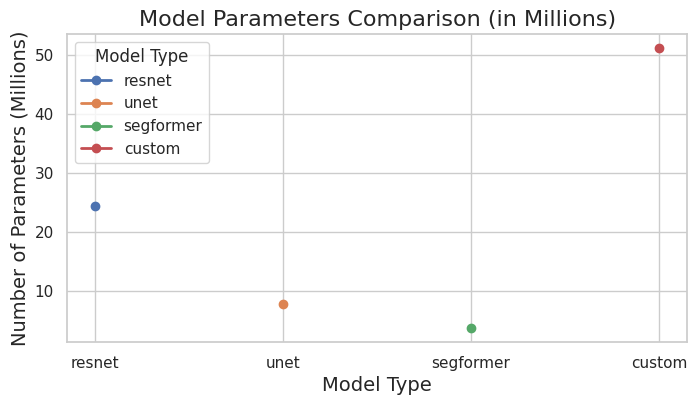

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
for idx, row in df_model_par.iterrows():
    plt.plot([row['model_type']], [row['parameters_num_millions']], label=row['model_type'], marker='o', linestyle='-', linewidth=2)
plt.title('Model Parameters Comparison (in Millions)', fontsize=16)
plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Number of Parameters (Millions)', fontsize=14)
plt.legend(title='Model Type')
plt.savefig(os.path.join(root_dir, "model_parameters_line_plot.png"), dpi=300)
plt.show()